# پروژه بازتولید مقاله SMV-SVM
**ارائه‌دهندگان:** محمد مهدی نصرتی، حسام ثروتی، امیرعلی محمدی  
**مقاله مرجع:** Efficient implementation techniques of an SVM-based speech/music classifier in SMV  
**نویسندگان مقاله:** Chungsoo Lim, Joon-Hyuk Chang


## مقدمه کوتاه
در این نوت‌بوک، بازتولید بخش‌های اصلی مقاله را با داده‌های موجود انجام دادیم و همه نتایج را داخل همین فایل ثبت کردیم.


## محدودیت‌های اجرا
به‌جای دیتاست اصلی مقاله از MUSAN استفاده شده و تحلیل زمان/انرژی به‌صورت شاخص‌های پروکسی گزارش شده است.


## خلاصه کار انجام‌شده
پیاده‌سازی SVM و روش‌های `filtering`، `skipping` و `combined` از صفر انجام شده و نتایج بخش‌های 5.4 تا 5.7 گزارش شده‌اند.


In [2]:

import random
import time
from pathlib import Path
from typing import Dict, List, Tuple
from IPython.display import display

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 220)


In [3]:

DATA_ROOT = Path('musan')
CACHE_ROOT = Path('artifacts/full_feature_cache')

FRAME_SEC = 0.02

IDX_ZCR = 4
IDX_MUSIC = 5

LABEL_SPEECH = 1
LABEL_MUSIC = -1
LABEL_SILENCE = 0

NORM_METRICS = ['overall_norm', 'speech_norm', 'music_norm']
SECTION57_COMPARE_METRICS = ['overall_norm', 'speech_norm']

TRAIN_RATIO = 0.8
TRAIN_TOTAL_SEC_PER_CLASS = 20 * 60

TRAIN_STRIDE = 10
MAX_TRAIN_FRAMES_PER_CLASS = 5000

N_TEST_FILES_PER_SET = 10
N_SEGMENTS_PER_FILE = 15
TEST_MODES = ['varied', 2, 5, 10]

SVM_PARAMS = dict(C=2.0, gamma=0.01, lr=0.01, max_iter=800, tol=1e-5)

FILTERING_PAPER = dict(eta_M=80.0, op='OR', eta_pr=6.0)
SKIPPING_PAPER = dict(skip_len=15, N=1, eta_speech=1, eta_music=1)
COMBINED_PAPER = dict(eta_M=80.0, op='OR', eta_pr=6.0, skip_len=16, N=1, eta_speech=1, eta_music=1)


def normalize_features(raw: np.ndarray) -> np.ndarray:
    """Normalize raw feature frames with the train-set mean and std."""
    return (np.asarray(raw, dtype=np.float32) - feat_mean) / feat_std


def calibrate_threshold_balanced_local(scores: np.ndarray, y: np.ndarray):
    """Pick score threshold that maximizes balanced accuracy on provided labels."""
    best_thr = 0.0
    best_ba = -1.0
    for thr in np.quantile(scores, np.linspace(0.01, 0.99, 99)):
        pred = np.where(scores >= thr, LABEL_SPEECH, LABEL_MUSIC)
        rec_s = np.mean(pred[y == LABEL_SPEECH] == LABEL_SPEECH)
        rec_m = np.mean(pred[y == LABEL_MUSIC] == LABEL_MUSIC)
        ba = 0.5 * (rec_s + rec_m)
        if ba > best_ba:
            best_ba = float(ba)
            best_thr = float(thr)
    return best_thr, best_ba


def build_baseline_cache_from_raw_score_fn(test_sets: Dict[str, list], raw_score_fn, threshold: float):
    """Compute and cache baseline scores/predictions plus measured ms/frame."""
    cache = {}
    times = []
    for mode, files in test_sets.items():
        mode_key = str(mode)
        for f in files:
            key = (mode_key, f['file_id'])
            t0 = time.perf_counter()
            scores = raw_score_fn(f['raw'])
            dt = time.perf_counter() - t0
            pred = np.where(scores >= threshold, LABEL_SPEECH, LABEL_MUSIC).astype(np.int64)
            cache[key] = {'scores': scores, 'pred': pred}
            times.append((dt, len(pred)))

    total_t = sum(t for t, n in times)
    total_n = sum(n for t, n in times)
    ms_per_frame = 1000.0 * (total_t / total_n) if total_n else np.nan
    return cache, ms_per_frame


## ۱) ساخت نمایه فایل‌ها از ویژگی‌های کش‌شده

In [4]:

assert DATA_ROOT.exists(), f'{DATA_ROOT} not found'
assert CACHE_ROOT.exists(), f'{CACHE_ROOT} not found. Run the full notebook once to create cache.'


def cache_path_for_audio(audio_path: Path) -> Path:
    """Map a MUSAN wav path to its cached feature path."""
    rel = audio_path.relative_to(DATA_ROOT).with_suffix('')
    return CACHE_ROOT / (str(rel).replace('/', '__') + '.npy')


rows = []
for cls, label in [('speech', LABEL_SPEECH), ('music', LABEL_MUSIC), ('noise', LABEL_SILENCE)]:
    for p in sorted((DATA_ROOT / cls).rglob('*.wav')):
        cp = cache_path_for_audio(p)
        if not cp.exists():
            continue
        n = int(np.load(cp, mmap_mode='r').shape[0])
        rows.append({
            'path': str(p),
            'cache_path': str(cp),
            'label_name': cls,
            'label': label,
            'n_frames': n,
            'duration_sec': n * FRAME_SEC,
        })

index_df = pd.DataFrame(rows)
index_df.groupby('label_name', as_index=False).agg(files=('path', 'count'), hours=('duration_sec', lambda x: float(np.sum(x)/3600.0)))


,label_name,files,hours
0,music,660,42.612933
1,noise,930,6.224011
2,speech,426,60.447594


In [5]:

def split_paths(paths: List[str], ratio: float, seed: int) -> Tuple[List[str], List[str]]:
    """Shuffle and split a path list into train/test subsets."""
    rng = random.Random(seed)
    p = list(paths)
    rng.shuffle(p)
    n = int(len(p) * ratio)
    return p[:n], p[n:]

speech_paths = index_df[index_df.label == LABEL_SPEECH]['cache_path'].tolist()
music_paths = index_df[index_df.label == LABEL_MUSIC]['cache_path'].tolist()

train_speech, test_speech = split_paths(speech_paths, TRAIN_RATIO, SEED)
train_music, test_music = split_paths(music_paths, TRAIN_RATIO, SEED + 1)

print('Train speech files:', len(train_speech))
print('Train music files :', len(train_music))
print('Test speech files :', len(test_speech))
print('Test music files  :', len(test_music))


Train speech files: 340
Train music files : 528
Test speech files : 86
Test music files  : 132


## ۲) ساخت داده طبق پروتکل مقاله

In [6]:

rng = np.random.default_rng(SEED)


def sample_feature_chunk(file_list: List[str], frames: int) -> np.ndarray:
    """Sample a contiguous feature chunk of fixed frame length from cached files."""
    for _ in range(120):
        cp = random.choice(file_list)
        x = np.load(cp)
        if x.shape[0] >= frames:
            st = int(rng.integers(0, x.shape[0] - frames + 1))
            return x[st:st + frames].astype(np.float32)

    cp = random.choice(file_list)
    x = np.load(cp)
    if x.shape[0] == 0:
        return np.zeros((frames, 6), dtype=np.float32)

    rep = int(np.ceil(frames / x.shape[0]))
    xx = np.vstack([x] * rep)
    st = int(rng.integers(0, xx.shape[0] - frames + 1))
    return xx[st:st + frames].astype(np.float32)


def build_training_corpus_20min(file_list: List[str], is_speech: bool, total_sec: float = TRAIN_TOTAL_SEC_PER_CLASS) -> np.ndarray:
    """Assemble a 20-minute train corpus with paper-like segment durations."""
    target_frames = int(round(total_sec / FRAME_SEC))
    out = []
    total = 0

    while total < target_frames:
        sec = random.uniform(6.0, 12.0) if is_speech else random.uniform(28.0, 30.0)
        fr = max(1, int(round(sec / FRAME_SEC)))
        chunk = sample_feature_chunk(file_list, fr)
        out.append(chunk)
        total += chunk.shape[0]

    return np.vstack(out)[:target_frames]


def build_test_file(mode) -> Tuple[np.ndarray, np.ndarray]:
    """Build one synthetic paper-style test file with alternating speech/music/silence."""
    feats = []
    labels = []

    for _ in range(N_SEGMENTS_PER_FILE):
        if mode == 'varied':
            speech_sec = random.uniform(6.0, 12.0)
            music_sec = random.uniform(28.0, 30.0)
            silence_sec = random.uniform(3.0, 15.0)
        else:
            speech_sec = float(mode)
            music_sec = float(mode)
            silence_sec = 0.5

        sf = max(1, int(round(speech_sec / FRAME_SEC)))
        mf = max(1, int(round(music_sec / FRAME_SEC)))
        zf = max(1, int(round(silence_sec / FRAME_SEC)))

        speech_chunk = sample_feature_chunk(test_speech, sf)
        music_chunk = sample_feature_chunk(test_music, mf)
        silence_chunk = np.zeros((zf, 6), dtype=np.float32)

        feats.extend([speech_chunk, music_chunk, silence_chunk])
        labels.extend([
            np.full(sf, LABEL_SPEECH, dtype=np.int64),
            np.full(mf, LABEL_MUSIC, dtype=np.int64),
            np.full(zf, LABEL_SILENCE, dtype=np.int64),
        ])

    return np.vstack(feats), np.concatenate(labels)


## ۳) پیاده‌سازی SVM از صفر

In [7]:

class TorchRBFSVM:
    def __init__(self, C=2.0, gamma=0.01, lr=0.01, max_iter=800, tol=1e-5):
        self.C = C
        self.gamma = gamma
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol

    def _rbf(self, X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
        x1 = (X1 * X1).sum(dim=1, keepdim=True)
        x2 = (X2 * X2).sum(dim=1).unsqueeze(0)
        d2 = torch.clamp(x1 + x2 - 2.0 * (X1 @ X2.T), min=0.0)
        return torch.exp(-self.gamma * d2)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X_t = torch.tensor(X, dtype=torch.float32)
        y_t = torch.tensor(y, dtype=torch.float32)

        K = self._rbf(X_t, X_t)
        Q = (y_t[:, None] * y_t[None, :]) * K

        alpha = torch.zeros(X_t.shape[0], dtype=torch.float32)
        y_norm = torch.dot(y_t, y_t)
        prev = -1e12

        for it in range(self.max_iter):
            grad = 1.0 - Q @ alpha
            alpha = torch.clamp(alpha + self.lr * grad, 0.0, self.C)
            alpha = alpha - y_t * (torch.dot(y_t, alpha) / (y_norm + 1e-8))
            alpha = torch.clamp(alpha, 0.0, self.C)

            if (it % 25 == 0) or (it == self.max_iter - 1):
                obj = torch.sum(alpha) - 0.5 * torch.dot(alpha, Q @ alpha)
                if abs((obj - prev).item()) < self.tol:
                    break
                prev = obj

        sv_mask = alpha > 1e-5
        self.sv = X_t[sv_mask].numpy().astype(np.float32)
        self.sv_y = y_t[sv_mask].numpy().astype(np.float32)
        self.alpha = alpha[sv_mask].numpy().astype(np.float32)
        self.alpha_y = self.alpha * self.sv_y

        if self.sv.shape[0] == 0:
            self.b = 0.0
            return

        margin = (alpha > 1e-5) & (alpha < self.C - 1e-5)
        if torch.any(margin):
            idx = torch.where(margin)[0][:256]
            b_vals = []
            for i in idx:
                k_col = K[sv_mask, i]
                fi = torch.sum(alpha[sv_mask] * y_t[sv_mask] * k_col)
                b_vals.append((y_t[i] - fi).item())
            self.b = float(np.mean(b_vals))
        else:
            dec = Q @ alpha
            self.b = float(torch.mean(y_t - dec).item())

    def decision_function(self, X: np.ndarray, batch: int = 512) -> np.ndarray:
        out = np.zeros((X.shape[0],), dtype=np.float32)
        if self.sv.shape[0] == 0:
            return out

        sv = self.sv
        ay = self.alpha_y
        sv2 = np.sum(sv * sv, axis=1)[None, :]

        for i in range(0, X.shape[0], batch):
            xb = X[i:i+batch]
            xb2 = np.sum(xb * xb, axis=1, keepdims=True)
            d2 = np.clip(xb2 + sv2 - 2.0 * (xb @ sv.T), 0.0, None)
            K = np.exp(-self.gamma * d2)
            out[i:i+batch] = K @ ay + self.b

        return out


## ۴) آموزش مدل پایه با ۲۰ دقیقه داده برای هر کلاس

In [8]:

X_speech_20m = build_training_corpus_20min(train_speech, is_speech=True, total_sec=TRAIN_TOTAL_SEC_PER_CLASS)
X_music_20m = build_training_corpus_20min(train_music, is_speech=False, total_sec=TRAIN_TOTAL_SEC_PER_CLASS)

print('20-min speech corpus frames:', X_speech_20m.shape[0])
print('20-min music corpus frames :', X_music_20m.shape[0])


X_speech_train = X_speech_20m[::TRAIN_STRIDE][:MAX_TRAIN_FRAMES_PER_CLASS]
X_music_train = X_music_20m[::TRAIN_STRIDE][:MAX_TRAIN_FRAMES_PER_CLASS]

X_train_raw = np.vstack([X_speech_train, X_music_train]).astype(np.float32)
y_train = np.concatenate([
    np.ones(X_speech_train.shape[0], dtype=np.int64),
    -np.ones(X_music_train.shape[0], dtype=np.int64),
])

perm = np.random.permutation(len(y_train))
X_train_raw = X_train_raw[perm]
y_train = y_train[perm]

feat_mean = X_train_raw.mean(axis=0)
feat_std = X_train_raw.std(axis=0) + 1e-6
X_train = (X_train_raw - feat_mean) / feat_std

print('SVM train matrix:', X_train.shape)

svm = TorchRBFSVM(**SVM_PARAMS)
t0 = time.perf_counter()
svm.fit(X_train, y_train)
train_sec = time.perf_counter() - t0

print(f'train time: {train_sec:.2f}s')
print('support vectors:', len(svm.alpha))
print('bias b:', svm.b)


20-min speech corpus frames: 60000
20-min music corpus frames : 60000
SVM train matrix: (10000, 6)
train time: 7.06s
support vectors: 8424
bias b: 486.1954737082124


In [9]:

train_scores = svm.decision_function(X_train)

best_thr, best_ba = calibrate_threshold_balanced_local(train_scores, y_train)

print('chosen threshold:', best_thr)
print('train balanced accuracy:', best_ba)


chosen threshold: -44.436276245117185
train balanced accuracy: 0.544


## ۵) مکانیزم‌های مقاله (پایه، فیلترینگ، پرش، ترکیبی)

In [10]:

METHOD_ORDER = ['Baseline', 'Filtering', 'Skipping', 'Combined']


def safe_div(a, b):
    """Safely divide two numbers and return NaN when denominator is zero."""
    return float(a) / float(b) if float(b) != 0.0 else np.nan


def f1_from_pr(p, r):
    """Compute F1 from precision and recall with NaN-safe guards."""
    if np.isnan(p) or np.isnan(r) or (p + r) == 0:
        return np.nan
    return 2.0 * p * r / (p + r)


def metrics_binary(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Compute overall/speech/music accuracy while ignoring silence frames."""
    m = y_true != LABEL_SILENCE
    yt = y_true[m]
    yp = y_pred[m]

    overall = float(np.mean(yp == yt))
    speech = float(np.mean(yp[yt == LABEL_SPEECH] == LABEL_SPEECH)) if np.any(yt == LABEL_SPEECH) else np.nan
    music = float(np.mean(yp[yt == LABEL_MUSIC] == LABEL_MUSIC)) if np.any(yt == LABEL_MUSIC) else np.nan

    return {'overall_acc': overall, 'speech_acc': speech, 'music_acc': music, 'n_eval': int(len(yt))}


def filtering_mask(raw: np.ndarray, eta_M: float, op: str, eta_pr: float) -> np.ndarray:
    """Return frame mask selected by filtering thresholds and boolean operator."""
    cond_M = raw[:, IDX_MUSIC] > eta_M
    cond_pr = raw[:, IDX_ZCR] > eta_pr
    return (cond_M & cond_pr) if op.upper() == 'AND' else (cond_M | cond_pr)


def run_filtering(raw: np.ndarray, baseline_pred: np.ndarray, eta_M: float, op: str, eta_pr: float):
    """Apply filtering rule and replace selected frames with music label."""
    mask = filtering_mask(raw, eta_M, op, eta_pr)
    pred = baseline_pred.copy()
    pred[mask] = LABEL_MUSIC
    info = {'filtered': int(np.sum(mask)), 'skipped': 0, 'svm_calls': int(len(pred) - np.sum(mask))}
    return pred, info


def _run_skipping_label(baseline_pred: np.ndarray, skip_len: int, N: int, eta_speech: int, eta_music: int, return_mask: bool = False):
    n = len(baseline_pred)
    pred = np.empty((n,), dtype=np.int64)
    skipped_mask = np.zeros((n,), dtype=bool) if return_mask else None

    hist = []
    nskip = 0
    cprev = LABEL_SPEECH
    skipped = 0
    svm_calls = 0

    for i in range(n):
        if nskip > 0:
            pred[i] = cprev
            skipped += 1
            nskip -= 1
            hist.append(cprev)
            if return_mask:
                skipped_mask[i] = True
            continue

        y = int(baseline_pred[i])
        pred[i] = y
        svm_calls += 1
        hist.append(y)

        if len(hist) >= N:
            tail = hist[-N:]
            if tail.count(LABEL_SPEECH) >= eta_speech:
                cprev = LABEL_SPEECH
                nskip = skip_len
            elif tail.count(LABEL_MUSIC) >= eta_music:
                cprev = LABEL_MUSIC
                nskip = skip_len

    info = {'filtered': 0, 'skipped': skipped, 'svm_calls': svm_calls}
    if return_mask:
        return pred, info, skipped_mask
    return pred, info


def run_skipping(baseline_pred: np.ndarray, skip_len: int, N: int, eta_speech: int, eta_music: int):
    """Apply label-history based skipping and return predictions plus call statistics."""
    return _run_skipping_label(baseline_pred, skip_len, N, eta_speech, eta_music, return_mask=False)


def run_skipping_with_mask(baseline_pred: np.ndarray, skip_len: int, N: int, eta_speech: int, eta_music: int):
    """Apply label-history skipping and also return a boolean skipped-frame mask."""
    return _run_skipping_label(baseline_pred, skip_len, N, eta_speech, eta_music, return_mask=True)


def run_skipping_score(baseline_pred: np.ndarray, baseline_scores: np.ndarray,
                       skip_len: int, N: int,
                       eta_score_speech: float, eta_score_music: float):
    """Apply score-history based skipping (paper section-3.2 equivalent)."""
    n = len(baseline_pred)
    pred = np.empty((n,), dtype=np.int64)

    score_hist = []
    nskip = 0
    cprev = LABEL_SPEECH
    skipped = 0
    svm_calls = 0

    for i in range(n):
        if nskip > 0:
            pred[i] = cprev
            skipped += 1
            nskip -= 1
            continue

        y = int(baseline_pred[i])
        pred[i] = y
        svm_calls += 1

        score_hist.append(float(baseline_scores[i]))
        if len(score_hist) >= N:
            mu = float(np.mean(score_hist[-N:]))
            if mu >= eta_score_speech:
                cprev = LABEL_SPEECH
                nskip = skip_len
            elif mu <= eta_score_music:
                cprev = LABEL_MUSIC
                nskip = skip_len

    info = {'filtered': 0, 'skipped': skipped, 'svm_calls': svm_calls}
    return pred, info


def run_combined(raw: np.ndarray, baseline_pred: np.ndarray,
                 eta_M: float, op: str, eta_pr: float,
                 skip_len: int, N: int, eta_speech: int, eta_music: int):
    """Run filtering and skipping together in filter-then-skip order."""
    n = len(baseline_pred)
    pred = np.empty((n,), dtype=np.int64)

    hist = []
    nskip = 0
    cprev = LABEL_SPEECH

    filtered = 0
    skipped = 0
    svm_calls = 0

    mask = filtering_mask(raw, eta_M, op, eta_pr)

    for i in range(n):
        if mask[i]:
            pred[i] = LABEL_MUSIC
            filtered += 1
            hist.append(LABEL_MUSIC)
            if nskip > 0:
                if cprev == LABEL_SPEECH:
                    nskip = 0
                else:
                    nskip = max(nskip - 1, 0)
            continue

        if nskip > 0:
            pred[i] = cprev
            skipped += 1
            nskip -= 1
            hist.append(cprev)
            continue

        y = int(baseline_pred[i])
        pred[i] = y
        svm_calls += 1
        hist.append(y)

        if len(hist) >= N:
            tail = hist[-N:]
            if tail.count(LABEL_SPEECH) >= eta_speech:
                cprev = LABEL_SPEECH
                nskip = skip_len
            elif tail.count(LABEL_MUSIC) >= eta_music:
                cprev = LABEL_MUSIC
                nskip = skip_len

    info = {'filtered': filtered, 'skipped': skipped, 'svm_calls': svm_calls}
    return pred, info


def apply_method(method_name: str, raw: np.ndarray, base_pred: np.ndarray, params: dict = None,
                 combined_order: str = 'filter_then_skip', base_scores: np.ndarray = None):
    """Run one evaluation mechanism and return predictions plus accounting info."""
    params = {} if params is None else params

    if method_name == 'Baseline':
        return base_pred, {'filtered': 0, 'skipped': 0, 'svm_calls': len(base_pred)}
    if method_name == 'Filtering':
        return run_filtering(raw, base_pred, **params)
    if method_name == 'Skipping':
        return run_skipping(base_pred, **params)
    if method_name == 'SkippingScore':
        if base_scores is None:
            raise ValueError('base_scores is required for SkippingScore')
        return run_skipping_score(base_pred, base_scores, **params)
    if method_name == 'Combined':
        if combined_order == 'filter_then_skip':
            return run_combined(raw, base_pred, **params)
        if combined_order == 'skip_then_filter':
            return run_combined_skip_then_filter(raw, base_pred, **params)
        raise ValueError(combined_order)
    raise ValueError(method_name)


def order_dataframe(df: pd.DataFrame, label_col: str, order: list = None) -> pd.DataFrame:
    """Return a dataframe sorted by an optional categorical label order."""
    if order is None:
        return df.copy()
    ordered = df.copy()
    ordered[label_col] = pd.Categorical(ordered[label_col], categories=order, ordered=True)
    return ordered.sort_values(label_col).reset_index(drop=True)


def plot_norm_bars(ax, df: pd.DataFrame, label_col: str, order: list = None,
                   title: str = '', show_legend: bool = True):
    """Plot grouped bars for normalized metrics on a provided axis."""
    ordered_df = order_dataframe(df, label_col=label_col, order=order)
    x = np.arange(len(ordered_df))
    width = 0.24
    for i, metric in enumerate(NORM_METRICS):
        ax.bar(x + (i - 1) * width, ordered_df[metric].values, width=width, label=metric if show_legend else None)
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_df[label_col])
    if title:
        ax.set_title(title)
    ax.grid(axis='y', alpha=0.25)
    if show_legend:
        ax.legend(fontsize=8)
    return ordered_df


def plot_norm_bars_and_tradeoff(df: pd.DataFrame, label_col: str, title_prefix: str,
                                order: list = None, figsize=(12, 4.8)):
    """Plot normalized bars and overall-ratio tradeoff scatter in one two-panel figure."""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    ordered_df = plot_norm_bars(
        axes[0],
        df,
        label_col=label_col,
        order=order,
        title=f'{title_prefix}: Normalized Accuracy',
        show_legend=True,
    )

    axes[1].scatter(ordered_df['overall_ratio'], ordered_df['overall_norm'], s=80)
    for _, row in ordered_df.iterrows():
        axes[1].annotate(str(row[label_col]), (row['overall_ratio'], row['overall_norm']), xytext=(5, 5), textcoords='offset points')
    axes[1].set_xlabel('Overall Ratio (filtered + skipped)')
    axes[1].set_ylabel('Overall Norm')
    axes[1].set_title(f'{title_prefix}: Quality vs Reduction')
    axes[1].grid(alpha=0.25)

    plt.tight_layout()
    plt.show()
    return fig, axes, ordered_df


def plot_norm_line_compare(ax, df: pd.DataFrame, label_col: str, dataset_col: str,
                           metric_col: str, order: list = None, title: str = ''):
    """Plot metric lines across methods for each dataset group on a provided axis."""
    for dataset_name in df[dataset_col].unique():
        dataset_df = df[df[dataset_col] == dataset_name].copy()
        dataset_df = order_dataframe(dataset_df, label_col=label_col, order=order)
        ax.plot(dataset_df[label_col].astype(str), dataset_df[metric_col].values, marker='o', label=dataset_name)
    if title:
        ax.set_title(title)
    ax.grid(alpha=0.25)
    ax.legend(fontsize=8)


## ۶) ساخت مجموعه‌های آزمون مقاله (۴ حالت × ۱۰ فایل)

In [11]:

paper_test_sets = {}
for mode in TEST_MODES:
    files = []
    for k in range(N_TEST_FILES_PER_SET):
        raw, y = build_test_file(mode)
        files.append({'raw': raw, 'y_true': y, 'mode': str(mode), 'file_id': k})
    paper_test_sets[str(mode)] = files

for mode, files in paper_test_sets.items():
    total_frames = int(sum(len(f['y_true']) for f in files))
    eval_frames = int(sum(np.sum(f['y_true'] != 0) for f in files))
    print(mode, 'files=', len(files), 'total_frames=', total_frames, 'eval_frames=', eval_frames)


varied files= 10 total_frames= 352539 eval_frames= 286030
2 files= 10 total_frames= 33750 eval_frames= 30000
5 files= 10 total_frames= 78750 eval_frames= 75000
10 files= 10 total_frames= 153750 eval_frames= 150000


In [12]:

def svm_score_raw(raw: np.ndarray) -> np.ndarray:
    """Score raw frames with the trained SVM after normalization."""
    return svm.decision_function(normalize_features(raw))


baseline_cache, baseline_ms_per_frame = build_baseline_cache_from_raw_score_fn(
    paper_test_sets,
    svm_score_raw,
    best_thr,
)
print('baseline measured ms/frame (paper synthetic sets):', baseline_ms_per_frame)


baseline measured ms/frame (paper synthetic sets): 0.041961379381367424


## ۷) نتایج اصلی به سبک مقاله

In [13]:

def evaluate_all_modes(method_name: str, params: dict) -> pd.DataFrame:
    """Evaluate one method across all paper test modes and files."""
    rows = []

    for mode, files in paper_test_sets.items():
        for f in files:
            key = (mode, f['file_id'])
            raw = f['raw']
            y_true = f['y_true']
            base_pred = baseline_cache[key]['pred']

            y_pred, info = apply_method(method_name, raw, base_pred, params=params)

            m = metrics_binary(y_true, y_pred)
            total = len(y_true)

            rows.append({
                'mode': mode,
                'file_id': f['file_id'],
                'method': method_name,
                **m,
                'filtered_ratio': info['filtered'] / total,
                'skipped_ratio': info['skipped'] / total,
                'overall_ratio': (info['filtered'] + info['skipped']) / total,
                'svm_call_ratio': info['svm_calls'] / total,
            })

    return pd.DataFrame(rows)


main_results = []
main_results.append(evaluate_all_modes('Baseline', {}))
main_results.append(evaluate_all_modes('Filtering', FILTERING_PAPER))
main_results.append(evaluate_all_modes('Skipping', SKIPPING_PAPER))
main_results.append(evaluate_all_modes('Combined', COMBINED_PAPER))

paper_results_raw = pd.concat(main_results, ignore_index=True)
paper_results_raw.head()


,mode,file_id,method,overall_acc,speech_acc,music_acc,n_eval,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio
0,varied,0,Baseline,0.371764,0.874694,0.220802,28276,0.0,0.0,0.0,1.0
1,varied,1,Baseline,0.337911,0.963667,0.149879,28469,0.0,0.0,0.0,1.0
2,varied,2,Baseline,0.297304,0.970342,0.099370,28338,0.0,0.0,0.0,1.0
3,varied,3,Baseline,0.386865,0.863422,0.232841,28687,0.0,0.0,0.0,1.0
4,varied,4,Baseline,0.371007,0.875940,0.214436,28641,0.0,0.0,0.0,1.0


In [14]:

paper_results_mean = (
    paper_results_raw
    .groupby(['mode', 'method'], as_index=False)[['overall_acc', 'speech_acc', 'music_acc', 'filtered_ratio', 'skipped_ratio', 'overall_ratio', 'svm_call_ratio']]
    .mean()
)
paper_results_mean


,mode,method,overall_acc,speech_acc,music_acc,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio
0,10,Baseline,0.525140,0.904147,0.146133,0.000000,0.000000,0.000000,1.000000
1,10,Combined,0.499333,0.000000,0.998667,0.974959,0.023050,0.998010,0.001990
2,10,Filtering,0.499333,0.000000,0.998667,0.974959,0.000000,0.974959,0.025041
3,10,Skipping,0.522827,0.899240,0.146413,0.000000,0.937496,0.937496,0.062504
4,2,Baseline,0.535500,0.915600,0.155400,0.000000,0.000000,0.000000,1.000000
5,2,Combined,0.500000,0.000000,1.000000,0.888889,0.102222,0.991111,0.008889
6,2,Filtering,0.500000,0.000000,1.000000,0.888889,0.000000,0.888889,0.111111
7,2,Skipping,0.532100,0.918267,0.145933,0.000000,0.937481,0.937481,0.062519
8,5,Baseline,0.528827,0.910933,0.146720,0.000000,0.000000,0.000000,1.000000
9,5,Combined,0.500000,0.000000,1.000000,0.952381,0.043810,0.996190,0.003810


In [15]:


norm_rows = []
for mode, g in paper_results_mean.groupby('mode'):
    b = g[g['method'] == 'Baseline'].iloc[0]
    for _, r in g.iterrows():
        norm_rows.append({
            'mode': mode,
            'method': r['method'],
            'overall_norm': r['overall_acc'] / b['overall_acc'],
            'speech_norm': r['speech_acc'] / b['speech_acc'],
            'music_norm': r['music_acc'] / b['music_acc'],
            'filtered_ratio': r['filtered_ratio'],
            'skipped_ratio': r['skipped_ratio'],
            'overall_ratio': r['overall_ratio'],
            'svm_call_ratio': r['svm_call_ratio'],
        })

paper_results_norm = pd.DataFrame(norm_rows)
paper_results_norm


,mode,method,overall_norm,speech_norm,music_norm,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio
0,10,Baseline,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
1,10,Combined,0.950858,0.000000,6.833942,0.974959,0.023050,0.998010,0.001990
2,10,Filtering,0.950858,0.000000,6.833942,0.974959,0.000000,0.974959,0.025041
3,10,Skipping,0.995595,0.994573,1.001916,0.000000,0.937496,0.937496,0.062504
4,2,Baseline,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
5,2,Combined,0.933707,0.000000,6.435006,0.888889,0.102222,0.991111,0.008889
6,2,Filtering,0.933707,0.000000,6.435006,0.888889,0.000000,0.888889,0.111111
7,2,Skipping,0.993651,1.002912,0.939082,0.000000,0.937481,0.937481,0.062519
8,5,Baseline,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
9,5,Combined,0.945489,0.000000,6.815703,0.952381,0.043810,0.996190,0.003810


In [16]:


agg = (
    paper_results_norm
    .groupby('method', as_index=False)[['overall_norm', 'speech_norm', 'music_norm', 'overall_ratio', 'svm_call_ratio']]
    .mean()
)
agg['estimated_exec_ms_per_frame'] = baseline_ms_per_frame * agg['svm_call_ratio']

paper_table6_like = agg[['method', 'overall_norm', 'speech_norm', 'music_norm', 'overall_ratio', 'estimated_exec_ms_per_frame']]
paper_table6_like


,method,overall_norm,speech_norm,music_norm,overall_ratio,estimated_exec_ms_per_frame
0,Baseline,1.000000,1.000000,1.000000,0.000000,0.041961
1,Combined,1.273185,0.000012,6.591547,0.993502,0.000273
2,Filtering,1.273185,0.000012,6.591547,0.906947,0.003905
3,Skipping,1.003746,1.001962,0.994345,0.937465,0.002624


## ۸) پیمایش فیلترینگ (سه‌تایی آستانه‌ها)

In [17]:

paper_triplets = [
    (80, 'AND', 4),
    (70, 'AND', 2),
    (80, 'OR', 6),
    (60, 'OR', 4),
    (30, 'AND', 1),
    (40, 'OR', 2),
]

rows = []
for eta_M, op, eta_pr in paper_triplets:
    df = evaluate_all_modes('Filtering', dict(eta_M=float(eta_M), op=op, eta_pr=float(eta_pr)))
    m = df.groupby('mode', as_index=False)[['overall_acc', 'speech_acc', 'music_acc', 'filtered_ratio']].mean()
    m['triplet'] = f'{{{eta_M}, {op}, {eta_pr}}}'
    rows.append(m)

filtering_sweep = pd.concat(rows, ignore_index=True)
filtering_sweep


,mode,overall_acc,speech_acc,music_acc,filtered_ratio,triplet
0,10,0.499280,0.000840,0.997720,0.974088,"{80, AND, 4}"
1,2,0.502033,0.004067,1.000000,0.887081,"{80, AND, 4}"
2,5,0.500667,0.001760,0.999573,0.951340,"{80, AND, 4}"
3,varied,0.762352,0.003908,1.000000,0.810818,"{80, AND, 4}"
4,10,0.499480,0.000707,0.998253,0.974413,"{70, AND, 2}"
5,2,0.501567,0.003133,1.000000,0.887496,"{70, AND, 2}"
6,5,0.500613,0.001360,0.999867,0.951670,"{70, AND, 2}"
7,varied,0.762176,0.003163,1.000000,0.810959,"{70, AND, 2}"
8,10,0.499333,0.000000,0.998667,0.974959,"{80, OR, 6}"
9,2,0.500000,0.000000,1.000000,0.888889,"{80, OR, 6}"


## ۹) تحلیل حساسیت پرش (N و طول پرش)

In [18]:

skip_lengths = [8, 16, 32]
N_values = [1, 4, 16]

rows = []
for sl in skip_lengths:
    for N in N_values:
        params = dict(skip_len=sl, N=N, eta_speech=N, eta_music=N)
        df = evaluate_all_modes('Skipping', params)
        m = df.groupby('mode', as_index=False)[['overall_acc', 'speech_acc', 'music_acc', 'overall_ratio']].mean()
        m['skip_len'] = sl
        m['N'] = N
        rows.append(m)

skipping_sweep = pd.concat(rows, ignore_index=True)
skipping_sweep


,mode,overall_acc,speech_acc,music_acc,overall_ratio,skip_len,N
0,10,0.524293,0.903920,0.144667,0.888846,8,1
1,2,0.534133,0.915133,0.153133,0.888889,8,1
2,5,0.528933,0.911653,0.146213,0.888889,8,1
3,varied,0.336613,0.902371,0.159546,0.888878,8,1
4,10,0.529873,0.913000,0.146747,0.858218,8,4
5,2,0.538033,0.924333,0.151733,0.860652,8,4
6,5,0.531773,0.917333,0.146213,0.859568,8,4
7,varied,0.337217,0.908195,0.158485,0.865042,8,4
8,10,0.532620,0.921813,0.143427,0.772820,8,16
9,2,0.536900,0.930867,0.142933,0.764296,8,16


## ۱۰) تحلیل بصری درون‌نوت‌بوک

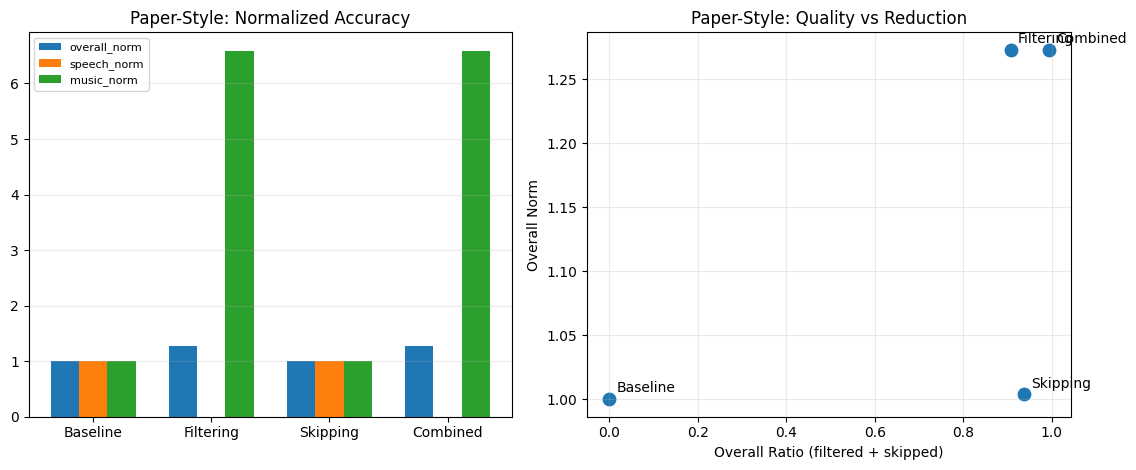

(<Figure size 1150x480 with 2 Axes>,
 array([<Axes: title={'center': 'Paper-Style: Normalized Accuracy'}>,
        <Axes: title={'center': 'Paper-Style: Quality vs Reduction'}, xlabel='Overall Ratio (filtered + skipped)', ylabel='Overall Norm'>],
       dtype=object),
       method  overall_norm  speech_norm  music_norm  overall_ratio  estimated_exec_ms_per_frame
 0   Baseline      1.000000     1.000000    1.000000       0.000000                     0.041961
 1  Filtering      1.273185     0.000012    6.591547       0.906947                     0.003905
 2   Skipping      1.003746     1.001962    0.994345       0.937465                     0.002624
 3   Combined      1.273185     0.000012    6.591547       0.993502                     0.000273)

In [19]:

plot_df = paper_table6_like.copy()
plot_norm_bars_and_tradeoff(
    plot_df,
    label_col='method',
    title_prefix='Paper-Style',
    order=METHOD_ORDER,
    figsize=(11.5, 4.8),
)


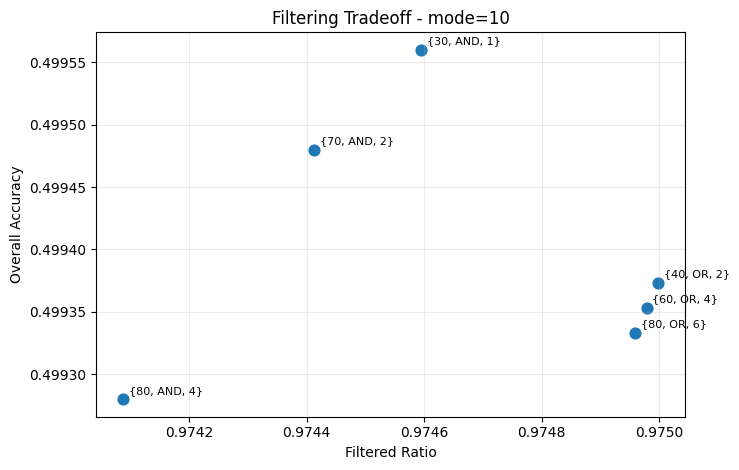

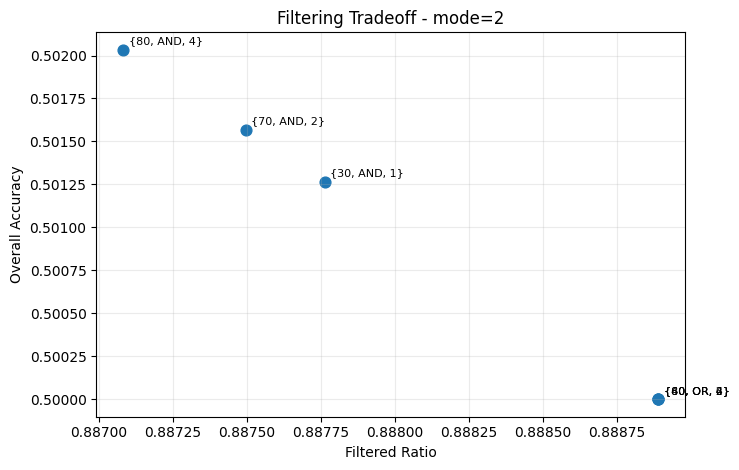

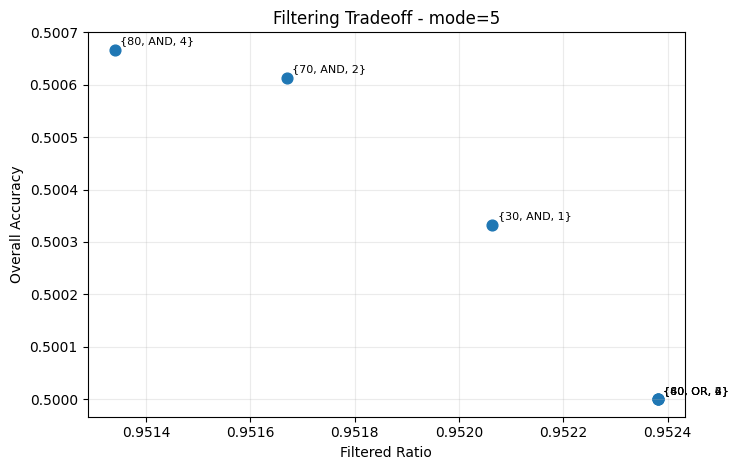

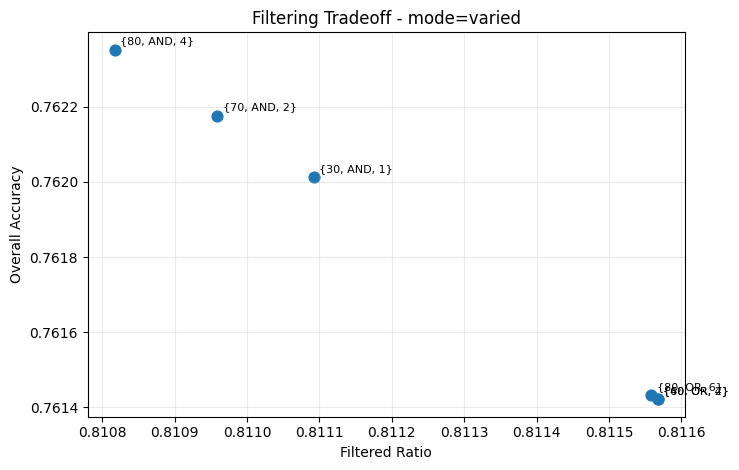

In [20]:


for mode in sorted(filtering_sweep['mode'].unique(), key=lambda x: str(x)):
    d = filtering_sweep[filtering_sweep['mode'] == mode]
    fig, ax = plt.subplots(figsize=(7.5, 4.8))
    ax.scatter(d['filtered_ratio'], d['overall_acc'], s=60)
    for _, r in d.iterrows():
        ax.annotate(r['triplet'], (r['filtered_ratio'], r['overall_acc']), xytext=(4, 4), textcoords='offset points', fontsize=8)
    ax.set_title(f'Filtering Tradeoff - mode={mode}')
    ax.set_xlabel('Filtered Ratio')
    ax.set_ylabel('Overall Accuracy')
    ax.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


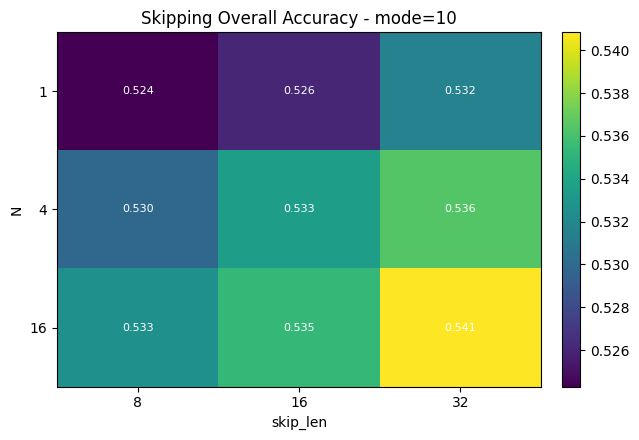

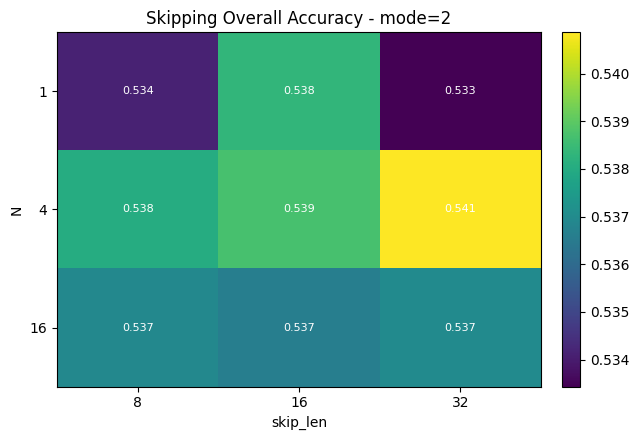

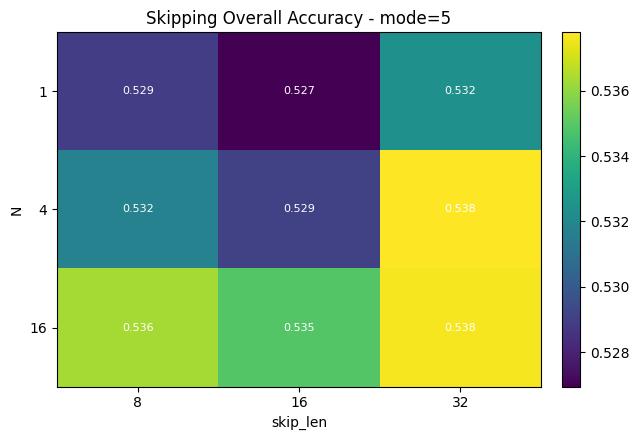

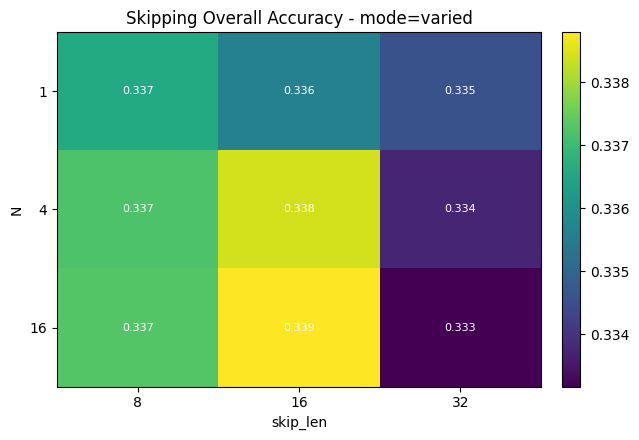

In [21]:


for mode in sorted(skipping_sweep['mode'].unique(), key=lambda x: str(x)):
    d = skipping_sweep[skipping_sweep['mode'] == mode]
    piv = d.pivot(index='N', columns='skip_len', values='overall_acc').sort_index().sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    im = ax.imshow(piv.values, aspect='auto', cmap='viridis')
    ax.set_xticks(range(len(piv.columns)))
    ax.set_xticklabels(piv.columns)
    ax.set_yticks(range(len(piv.index)))
    ax.set_yticklabels(piv.index)
    ax.set_xlabel('skip_len')
    ax.set_ylabel('N')
    ax.set_title(f'Skipping Overall Accuracy - mode={mode}')

    for i in range(piv.shape[0]):
        for j in range(piv.shape[1]):
            ax.text(j, i, f"{piv.values[i, j]:.3f}", ha='center', va='center', color='white', fontsize=8)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


## ۱۱) تفسیر نتایج
- جدول `paper_table6_like` نزدیک‌ترین خروجی ما به جدول ۶ مقاله در این محیط است.
- جدول `paper_results_norm` دقت‌های نرمال‌شده را به تفکیک حالت آزمون نشان می‌دهد.
- خروجی‌های `filtering_sweep` و `skipping_sweep` تحلیل حساسیت‌های بخش‌های 5.2 و 5.3 مقاله را بازتولید می‌کنند.


## ۱۲) تکمیل مقاله: پرش مبتنی بر خروجی SVM (روابط ۱۸ تا ۲۰)
در این بخش، مکانیزم دوم پرش که در بخش 3.2 مقاله مطرح شده (بر اساس میانگین خروجی‌های قبلی SVM) اضافه شده است.
طبق متن مقاله، نتایج این روش با روش پرش مبتنی بر تاریخچه برچسب مقایسه می‌شود تا بازتولید کامل‌تر باشد.


In [22]:

def evaluate_skipping_score_all_modes(skip_len: int, N: int, eta_score_speech: float, eta_score_music: float) -> pd.DataFrame:
    """Evaluate score-history skipping on all modes for one parameter setting."""
    rows = []
    params = {
        'skip_len': skip_len,
        'N': N,
        'eta_score_speech': eta_score_speech,
        'eta_score_music': eta_score_music,
    }
    for mode, files in paper_test_sets.items():
        for f in files:
            key = (mode, f['file_id'])
            raw = f['raw']
            y_true = f['y_true']
            base_pred = baseline_cache[key]['pred']
            base_scores = baseline_cache[key]['scores']

            y_pred, info = apply_method(
                'SkippingScore',
                raw,
                base_pred,
                params=params,
                base_scores=base_scores,
            )

            m = metrics_binary(y_true, y_pred)
            total = len(y_true)
            rows.append({
                'mode': mode,
                'file_id': f['file_id'],
                'method': 'SkippingScore',
                **m,
                'filtered_ratio': 0.0,
                'skipped_ratio': info['skipped'] / total,
                'overall_ratio': info['skipped'] / total,
                'svm_call_ratio': info['svm_calls'] / total,
            })
    return pd.DataFrame(rows)


def _meets_2pct(overall_row: pd.Series, baseline_row: pd.Series) -> bool:
    return (
        (overall_row['overall_acc'] >= 0.98 * baseline_row['overall_acc']) and
        (overall_row['speech_acc'] >= 0.98 * baseline_row['speech_acc']) and
        (overall_row['music_acc'] >= 0.98 * baseline_row['music_acc'])
    )


base_overall = (
    evaluate_all_modes('Baseline', {})
    .groupby('method', as_index=False)[['overall_acc', 'speech_acc', 'music_acc']]
    .mean()
    .iloc[0]
)


speech_train_scores = train_scores[y_train == 1]
music_train_scores = train_scores[y_train == -1]
eta_speech_candidates = [float(x) for x in np.quantile(speech_train_scores, [0.10, 0.25, 0.40, 0.55])]
eta_music_candidates = [float(x) for x in np.quantile(music_train_scores, [0.45, 0.60, 0.75, 0.90])]

score_skip_rows = []
for sl in [8, 16, 32]:
    for N in [1, 4, 16]:
        for et_s in eta_speech_candidates:
            for et_m in eta_music_candidates:
                df = evaluate_skipping_score_all_modes(sl, N, et_s, et_m)
                if len(df) == 0:
                    continue
                ov = df[['overall_acc', 'speech_acc', 'music_acc', 'overall_ratio', 'svm_call_ratio']].mean()
                score_skip_rows.append({
                    'skip_len': sl,
                    'N': N,
                    'eta_score_speech': et_s,
                    'eta_score_music': et_m,
                    **ov.to_dict(),
                    'feasible': _meets_2pct(ov, base_overall),
                })

if len(score_skip_rows) == 0:
    raise RuntimeError('Score-based skipping search produced no candidates; check test-set construction.')

score_skip_search = pd.DataFrame(score_skip_rows).sort_values('overall_ratio', ascending=False).reset_index(drop=True)
score_skip_feasible = score_skip_search[score_skip_search['feasible']].copy()
score_skip_best = (score_skip_feasible if len(score_skip_feasible) else score_skip_search).iloc[0]

best_score_skip_df = evaluate_skipping_score_all_modes(
    int(score_skip_best['skip_len']),
    int(score_skip_best['N']),
    float(score_skip_best['eta_score_speech']),
    float(score_skip_best['eta_score_music']),
)
best_score_skip_overall = best_score_skip_df[['overall_acc', 'speech_acc', 'music_acc', 'overall_ratio', 'svm_call_ratio']].mean()

label_skip_df = evaluate_all_modes('Skipping', SKIPPING_PAPER)
label_skip_overall = label_skip_df[['overall_acc', 'speech_acc', 'music_acc', 'overall_ratio', 'svm_call_ratio']].mean()

score_skip_table = pd.DataFrame([
    {
        'variant': 'Skipping by previous classifications (paper main)',
        'params': str(SKIPPING_PAPER),
        **label_skip_overall.to_dict(),
    },
    {
        'variant': 'Skipping by previous SVM outputs (paper second)',
        'params': f"skip_len={int(score_skip_best['skip_len'])}, N={int(score_skip_best['N'])}, eta_o_s={score_skip_best['eta_score_speech']:.3f}, eta_o_m={score_skip_best['eta_score_music']:.3f}",
        **best_score_skip_overall.to_dict(),
    },
])
score_skip_table['overall_norm'] = score_skip_table['overall_acc'] / float(base_overall['overall_acc'])
score_skip_table['speech_norm'] = score_skip_table['speech_acc'] / float(base_overall['speech_acc'])
score_skip_table['music_norm'] = score_skip_table['music_acc'] / float(base_overall['music_acc'])
score_skip_table


,variant,params,overall_acc,speech_acc,music_acc,overall_ratio,svm_call_ratio,overall_norm,speech_norm,music_norm
0,Skipping by previous classifications (paper main),"{'skip_len': 15, 'N': 1, 'eta_speech': 1, 'eta...",0.482507,0.910224,0.151068,0.937465,0.062535,1.00210,1.001979,0.994770
1,Skipping by previous SVM outputs (paper second),"skip_len=32, N=4, eta_o_s=-30.286, eta_o_m=-6.586",0.491405,0.907448,0.164566,0.969240,0.030760,1.02058,0.998923,1.083654


,variant,params,overall_norm,speech_norm,music_norm,overall_ratio
0,Skipping by previous classifications (paper main),"{'skip_len': 15, 'N': 1, 'eta_speech': 1, 'eta...",1.00210,1.001979,0.994770,0.937465
1,Skipping by previous SVM outputs (paper second),"skip_len=32, N=4, eta_o_s=-30.286, eta_o_m=-6.586",1.02058,0.998923,1.083654,0.969240


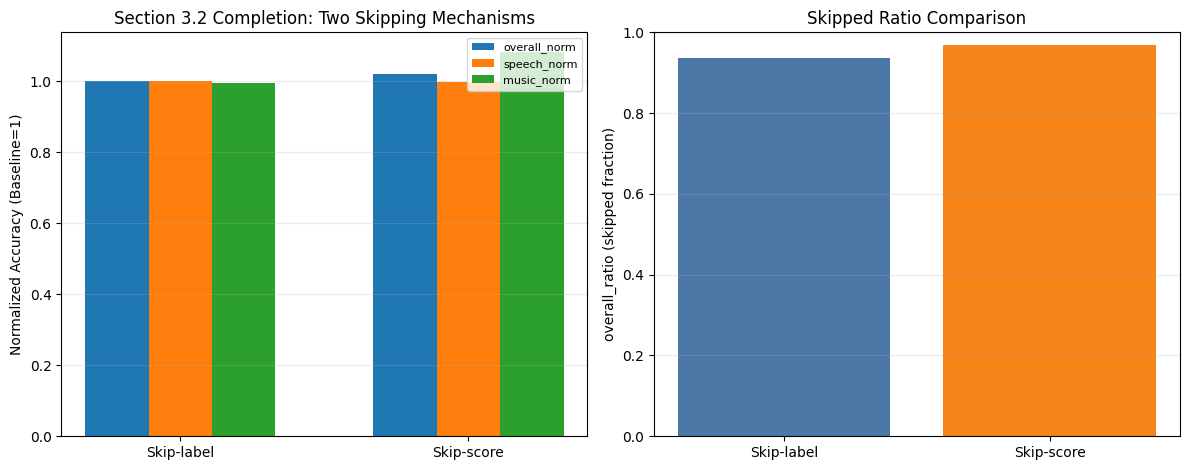

Best score-based skipping candidate (under <=2% rule when feasible):


,skip_len,N,eta_score_speech,eta_score_music,overall_acc,speech_acc,music_acc,overall_ratio,svm_call_ratio,feasible
20,32,4,-30.286041,-6.586,0.491405,0.907448,0.164566,0.96924,0.03076,True


In [23]:

display_cols = ['variant', 'params', *NORM_METRICS, 'overall_ratio']
display(score_skip_table[display_cols])

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

x = np.arange(len(score_skip_table))
w = 0.22
for i, metric in enumerate(NORM_METRICS):
    axes[0].bar(x + (i - 1) * w, score_skip_table[metric].values, width=w, label=metric)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Skip-label', 'Skip-score'])
axes[0].set_title('Section 3.2 Completion: Two Skipping Mechanisms')
axes[0].set_ylabel('Normalized Accuracy (Baseline=1)')
axes[0].grid(axis='y', alpha=0.25)
axes[0].legend(fontsize=8)

axes[1].bar(['Skip-label', 'Skip-score'], score_skip_table['overall_ratio'].values, color=['#4C78A8', '#F58518'])
axes[1].set_ylim(0.0, 1.0)
axes[1].set_title('Skipped Ratio Comparison')
axes[1].set_ylabel('overall_ratio (skipped fraction)')
axes[1].grid(axis='y', alpha=0.25)

plt.tight_layout()
plt.show()

print('Best score-based skipping candidate (under <=2% rule when feasible):')
display(score_skip_best.to_frame().T)


## ۱۳) تکمیل بخش‌های مقاله (5.4، 5.5، 5.6، 5.7)
در این قسمت چهار بخش تکمیلی مقاله که برای بازتولید کامل لازم هستند پوشش داده می‌شوند:
- بخش 5.4: مقایسه ترتیب‌های مکانیزم ترکیبی و اثر پارامترها (همتای جدول‌های ۲ تا ۴)
- بخش 5.5: انتخاب پارامتر تحت قید افت دقت و ارائه جدول‌های جمع‌بندی (همتای ۵ و ۶)
- بخش 5.6: ارزیابی تعمیم‌پذیری روی GMM و WSVM
- بخش 5.7: ارزیابی روی داده متفاوت (پروکسی انتقال/تخریب)

یادداشت روش‌شناسی:
- در نبود دیتاست و ابزار سخت‌افزاری دقیق مقاله، نتایج زمان/انرژی به‌صورت شاخص‌های پروکسی گزارش می‌شوند.


In [24]:

SEC54_F1 = dict(eta_M=60.0, op='OR', eta_pr=4.0)
SEC54_F2 = dict(eta_M=80.0, op='AND', eta_pr=4.0)
SEC54_S1 = dict(skip_len=8, N=4, eta_speech=4, eta_music=4)
SEC54_S2 = dict(skip_len=4, N=16, eta_speech=16, eta_music=16)

SEC55_CFG = {
    'filter_eta_M_values': [30, 40, 50, 60, 70, 80, 90, 100],
    'filter_ops': ['AND', 'OR'],
    'filter_eta_pr_values': [1, 2, 4, 6, 7, 8],
    'filter_extras': [
        {'eta_M': 80, 'op': 'OR', 'eta_pr': 6},
        {'eta_M': 60, 'op': 'OR', 'eta_pr': 4},
        {'eta_M': 80, 'op': 'AND', 'eta_pr': 4},
    ],
    'skip_lengths': [4, 8, 10, 12, 14, 15, 16, 17, 32],
    'skip_n_values': [1, 2, 4, 8, 16],
    'top_k': 12,
}

SEC56_CFG = {
    'filter_eta_M_values': [40, 50, 60, 70, 80, 90, 100],
    'filter_ops': ['AND', 'OR'],
    'filter_eta_pr_values': [1, 2, 4, 6, 7, 8],
    'filter_extras': [
        {'eta_M': 50, 'op': 'AND', 'eta_pr': 2},
        {'eta_M': 80, 'op': 'OR', 'eta_pr': 6},
        {'eta_M': 100, 'op': 'OR', 'eta_pr': 8},
    ],
    'skip_lengths': [8, 10, 12, 14, 16, 17, 32],
    'skip_n_values': [1, 2, 4, 8, 16],
    'top_k': 10,
}

SEC57_CFG = {
    'filter_eta_M_values': [60, 70, 80, 90, 100],
    'filter_ops': ['AND', 'OR'],
    'filter_eta_pr_values': [4, 6, 7, 8],
    'filter_extras': [
        {'eta_M': 90, 'op': 'OR', 'eta_pr': 7},
        {'eta_M': 80, 'op': 'OR', 'eta_pr': 6},
    ],
    'skip_lengths': [10, 12, 14, 15, 16, 17, 32],
    'skip_n_values': [1, 2, 4, 8, 16],
    'top_k': 12,
}

SEC56_ENERGY_FACTOR = {
    'GMM': 0.429 / 0.107,
    'WSVM': 61.148 / 17.200,
}


def run_combined_skip_then_filter(raw: np.ndarray, baseline_pred: np.ndarray,
                                  eta_M: float, op: str, eta_pr: float,
                                  skip_len: int, N: int, eta_speech: int, eta_music: int):
    """Run combined method in skip-then-filter order and return predictions and accounting."""
    pred_skip, info_skip, skipped_mask = run_skipping_with_mask(
        baseline_pred,
        skip_len=skip_len,
        N=N,
        eta_speech=eta_speech,
        eta_music=eta_music,
    )
    mask = filtering_mask(raw, eta_M=eta_M, op=op, eta_pr=eta_pr)
    filt_mask = mask & (~skipped_mask)

    pred = pred_skip.copy()
    pred[filt_mask] = LABEL_MUSIC

    info = {
        'filtered': int(np.sum(filt_mask)),
        'skipped': int(info_skip['skipped']),
        'svm_calls': int(info_skip['svm_calls']),
    }
    return pred, info


def counts_on_nonzero(y_true: np.ndarray, y_pred: np.ndarray):
    """Compute TP/TN/FP/FN counts on non-silence frames only."""
    m = y_true != LABEL_SILENCE
    yt = y_true[m]
    yp = y_pred[m]

    tp = int(np.sum((yt == LABEL_SPEECH) & (yp == LABEL_SPEECH)))
    tn = int(np.sum((yt == LABEL_MUSIC) & (yp == LABEL_MUSIC)))
    fp = int(np.sum((yt == LABEL_MUSIC) & (yp == LABEL_SPEECH)))
    fn = int(np.sum((yt == LABEL_SPEECH) & (yp == LABEL_MUSIC)))

    return tp, tn, fp, fn, int(len(yt))


def metrics_from_counts(tp: int, tn: int, fp: int, fn: int):
    """Convert confusion counts to accuracy/recall/precision/F1 metrics."""
    n = tp + tn + fp + fn
    if n == 0:
        return {
            'n_eval': 0,
            'accuracy': np.nan,
            'recall_speech': np.nan,
            'recall_music': np.nan,
            'precision_speech': np.nan,
            'precision_music': np.nan,
            'macro_f1': np.nan,
            'weighted_f1': np.nan,
        }

    rec_s = safe_div(tp, tp + fn)
    rec_m = safe_div(tn, tn + fp)
    pre_s = safe_div(tp, tp + fp)
    pre_m = safe_div(tn, tn + fn)

    f1_s = f1_from_pr(pre_s, rec_s)
    f1_m = f1_from_pr(pre_m, rec_m)

    macro_f1 = np.nanmean([f1_s, f1_m])
    weighted_f1 = safe_div(f1_s * (tp + fn) + f1_m * (tn + fp), n)

    return {
        'n_eval': int(n),
        'accuracy': safe_div(tp + tn, n),
        'recall_speech': rec_s,
        'recall_music': rec_m,
        'precision_speech': pre_s,
        'precision_music': pre_m,
        'macro_f1': float(macro_f1),
        'weighted_f1': float(weighted_f1),
    }


def evaluate_method_on_sets_detailed(test_sets: Dict[str, list], baseline_cache_local: dict,
                                     method_name: str, params: dict = None,
                                     combined_order: str = 'filter_then_skip'):
    """Evaluate one method over all sets and return per-mode and global aggregate metrics."""
    if params is None:
        params = {}

    mode_acc = {
        str(mode): {
            'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'n_eval': 0,
            'filtered': 0, 'skipped': 0, 'svm_calls': 0, 'total_frames': 0,
        }
        for mode in test_sets.keys()
    }
    overall = {
        'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'n_eval': 0,
        'filtered': 0, 'skipped': 0, 'svm_calls': 0, 'total_frames': 0,
    }

    for mode, files in test_sets.items():
        mode_key = str(mode)
        for f in files:
            key = (mode_key, f['file_id'])
            raw = f['raw']
            y_true = f['y_true']
            base_pred = baseline_cache_local[key]['pred']

            y_pred, info = apply_method(
                method_name,
                raw,
                base_pred,
                params=params,
                combined_order=combined_order,
            )

            tp, tn, fp, fn, n_eval = counts_on_nonzero(y_true, y_pred)
            total = len(y_true)

            mode_acc[mode_key]['tp'] += tp
            mode_acc[mode_key]['tn'] += tn
            mode_acc[mode_key]['fp'] += fp
            mode_acc[mode_key]['fn'] += fn
            mode_acc[mode_key]['n_eval'] += n_eval
            mode_acc[mode_key]['filtered'] += int(info['filtered'])
            mode_acc[mode_key]['skipped'] += int(info['skipped'])
            mode_acc[mode_key]['svm_calls'] += int(info['svm_calls'])
            mode_acc[mode_key]['total_frames'] += int(total)

            overall['tp'] += tp
            overall['tn'] += tn
            overall['fp'] += fp
            overall['fn'] += fn
            overall['n_eval'] += n_eval
            overall['filtered'] += int(info['filtered'])
            overall['skipped'] += int(info['skipped'])
            overall['svm_calls'] += int(info['svm_calls'])
            overall['total_frames'] += int(total)

    mode_rows = []
    for mode_key, s in mode_acc.items():
        met = metrics_from_counts(s['tp'], s['tn'], s['fp'], s['fn'])
        total = max(s['total_frames'], 1)
        mode_rows.append({
            'mode': mode_key,
            'method': method_name,
            **met,
            'overall_ratio': safe_div(s['filtered'] + s['skipped'], total),
            'filtered_ratio': safe_div(s['filtered'], total),
            'skipped_ratio': safe_div(s['skipped'], total),
            'svm_call_ratio': safe_div(s['svm_calls'], total),
        })

    met_all = metrics_from_counts(overall['tp'], overall['tn'], overall['fp'], overall['fn'])
    total_all = max(overall['total_frames'], 1)
    overall_row = {
        'method': method_name,
        **met_all,
        'overall_ratio': safe_div(overall['filtered'] + overall['skipped'], total_all),
        'filtered_ratio': safe_div(overall['filtered'], total_all),
        'skipped_ratio': safe_div(overall['skipped'], total_all),
        'svm_call_ratio': safe_div(overall['svm_calls'], total_all),
    }

    mode_df = pd.DataFrame(mode_rows).sort_values('mode').reset_index(drop=True)
    return mode_df, overall_row


def mode_normalized_vs_baseline(mode_df: pd.DataFrame, baseline_mode_df: pd.DataFrame, variant: str):
    """Normalize mode-wise metrics of one variant relative to baseline mode metrics."""
    b = baseline_mode_df[['mode', 'accuracy', 'recall_speech', 'recall_music']].rename(
        columns={
            'accuracy': 'accuracy_base',
            'recall_speech': 'recall_speech_base',
            'recall_music': 'recall_music_base',
        }
    )
    d = mode_df.merge(b, on='mode', how='left')

    out = d[['mode', 'overall_ratio', 'filtered_ratio', 'skipped_ratio']].copy()
    out['variant'] = variant

    den = d['accuracy_base'].to_numpy(dtype=float)
    out['overall_norm'] = np.where(den != 0.0, d['accuracy'].to_numpy(dtype=float) / den, np.nan)

    den = d['recall_speech_base'].to_numpy(dtype=float)
    out['speech_norm'] = np.where(den != 0.0, d['recall_speech'].to_numpy(dtype=float) / den, np.nan)

    den = d['recall_music_base'].to_numpy(dtype=float)
    out['music_norm'] = np.where(den != 0.0, d['recall_music'].to_numpy(dtype=float) / den, np.nan)

    return out[['mode', 'variant', *NORM_METRICS, 'overall_ratio', 'filtered_ratio', 'skipped_ratio']]


def feasible_under_2pct(metrics: dict, baseline: dict):
    """Check whether three key metrics stay within 2% of baseline."""
    keys = ['accuracy', 'recall_speech', 'recall_music']
    for k in keys:
        if np.isnan(metrics[k]) or np.isnan(baseline[k]):
            return False
        if metrics[k] < 0.98 * baseline[k]:
            return False
    return True


def unique_filter_candidates(cands):
    """Deduplicate filtering candidates by normalized (eta_M, op, eta_pr) tuple."""
    out = []
    seen = set()
    for p in cands:
        key = (float(p['eta_M']), str(p['op']).upper(), float(p['eta_pr']))
        if key in seen:
            continue
        seen.add(key)
        out.append({'eta_M': key[0], 'op': key[1], 'eta_pr': key[2]})
    return out


def unique_skip_candidates(cands):
    """Deduplicate skipping candidates by integer parameter tuple."""
    out = []
    seen = set()
    for p in cands:
        key = (int(p['skip_len']), int(p['N']), int(p['eta_speech']), int(p['eta_music']))
        if key in seen:
            continue
        seen.add(key)
        out.append({'skip_len': key[0], 'N': key[1], 'eta_speech': key[2], 'eta_music': key[3]})
    return out


def make_filter_candidates(eta_M_values, ops, eta_pr_values, extras=None):
    """Build filtering-candidate list from cartesian product and optional extras."""
    extras = [] if extras is None else list(extras)
    base = [
        {'eta_M': m, 'op': op, 'eta_pr': pr}
        for m in eta_M_values
        for op in ops
        for pr in eta_pr_values
    ]
    return unique_filter_candidates(base + extras)


def make_skip_candidates(skip_lengths, n_values):
    """Build skipping-candidate list from cartesian product of lengths and N values."""
    base = [
        {'skip_len': sl, 'N': N, 'eta_speech': N, 'eta_music': N}
        for sl in skip_lengths
        for N in n_values
    ]
    return unique_skip_candidates(base)


def build_candidates_from_cfg(section_cfg: dict):
    """Build filter/skip candidate lists from one section config dictionary."""
    filter_candidates = make_filter_candidates(
        eta_M_values=section_cfg['filter_eta_M_values'],
        ops=section_cfg['filter_ops'],
        eta_pr_values=section_cfg['filter_eta_pr_values'],
        extras=section_cfg['filter_extras'],
    )
    skip_candidates = make_skip_candidates(
        skip_lengths=section_cfg['skip_lengths'],
        n_values=section_cfg['skip_n_values'],
    )
    return filter_candidates, skip_candidates


def _evaluate_filter_candidates(test_sets, baseline_cache_local, filter_candidates, overall_base):
    rows = []
    for filter_params in filter_candidates:
        _, filter_metrics = evaluate_method_on_sets_detailed(test_sets, baseline_cache_local, 'Filtering', filter_params)
        rows.append({**filter_params, **filter_metrics, 'feasible': feasible_under_2pct(filter_metrics, overall_base)})
    return pd.DataFrame(rows)


def _evaluate_skip_candidates(test_sets, baseline_cache_local, skip_candidates, overall_base):
    rows = []
    for skip_params in skip_candidates:
        _, skip_metrics = evaluate_method_on_sets_detailed(test_sets, baseline_cache_local, 'Skipping', skip_params)
        rows.append({**skip_params, **skip_metrics, 'feasible': feasible_under_2pct(skip_metrics, overall_base)})
    return pd.DataFrame(rows)


def _top_candidate_records(df, top_k):
    feasible_df = df[df['feasible']].copy()
    use_df = feasible_df if len(feasible_df) > 0 else df
    return use_df.sort_values('overall_ratio', ascending=False).head(top_k).to_dict('records')


def _evaluate_combined_candidates(test_sets, baseline_cache_local, top_filter_records, top_skip_records, overall_base):
    rows = []
    for filter_record in top_filter_records:
        filter_params = {
            'eta_M': float(filter_record['eta_M']),
            'op': filter_record['op'],
            'eta_pr': float(filter_record['eta_pr']),
        }
        for skip_record in top_skip_records:
            skip_params = {
                'skip_len': int(skip_record['skip_len']),
                'N': int(skip_record['N']),
                'eta_speech': int(skip_record['eta_speech']),
                'eta_music': int(skip_record['eta_music']),
            }
            combined_params = {**filter_params, **skip_params}
            _, combined_metrics = evaluate_method_on_sets_detailed(
                test_sets,
                baseline_cache_local,
                'Combined',
                combined_params,
                combined_order='filter_then_skip',
            )
            rows.append({**combined_params, **combined_metrics, 'feasible': feasible_under_2pct(combined_metrics, overall_base)})
    return pd.DataFrame(rows)


def _choose_best_candidate(df):
    feasible_df = df[df['feasible']].copy()
    if len(feasible_df) > 0:
        return feasible_df.sort_values('overall_ratio', ascending=False).iloc[0].to_dict()
    return df.sort_values('overall_ratio', ascending=False).iloc[0].to_dict()


def search_params_under_constraint(test_sets: Dict[str, list], baseline_cache_local: dict,
                                   filter_candidates: list, skip_candidates: list,
                                   top_k: int = 10):
    """Search filtering/skipping/combined parameters under <=2% degradation rule."""
    mode_base, overall_base = evaluate_method_on_sets_detailed(test_sets, baseline_cache_local, 'Baseline', {})

    filter_df = _evaluate_filter_candidates(test_sets, baseline_cache_local, filter_candidates, overall_base)
    skip_df = _evaluate_skip_candidates(test_sets, baseline_cache_local, skip_candidates, overall_base)

    top_filter_records = _top_candidate_records(filter_df, top_k)
    top_skip_records = _top_candidate_records(skip_df, top_k)
    combined_df = _evaluate_combined_candidates(
        test_sets,
        baseline_cache_local,
        top_filter_records,
        top_skip_records,
        overall_base,
    )

    best_filter = _choose_best_candidate(filter_df)
    best_skip = _choose_best_candidate(skip_df)
    best_combined = _choose_best_candidate(combined_df)

    return {
        'baseline_mode': mode_base,
        'baseline_overall': overall_base,
        'filter_df': filter_df,
        'skip_df': skip_df,
        'comb_df': combined_df,
        'best_filter': best_filter,
        'best_skip': best_skip,
        'best_combined': best_combined,
    }


def format_filter_triplet(p: dict):
    """Render filtering params as paper-style threshold triplet string."""
    return f"{{{int(round(float(p['eta_M'])))}, {str(p['op']).upper()}, {int(round(float(p['eta_pr'])))}}}"


def build_mechanism_param_table(best_filter: dict, best_skip: dict, best_combined: dict, classifier: str = None):
    """Build a compact parameter summary table for Filtering/Skipping/Combined."""
    rows = [
        {
            'Mechanism': 'Filtering',
            'Filtering threshold triplet': format_filter_triplet(best_filter),
            'Skip length': '-',
            'N/threshold': '-',
        },
        {
            'Mechanism': 'Skipping',
            'Filtering threshold triplet': '-',
            'Skip length': int(best_skip['skip_len']),
            'N/threshold': f"{int(best_skip['N'])}/{int(best_skip['eta_speech'])}",
        },
        {
            'Mechanism': 'Combined',
            'Filtering threshold triplet': format_filter_triplet(best_combined),
            'Skip length': int(best_combined['skip_len']),
            'N/threshold': f"{int(best_combined['N'])}/{int(best_combined['eta_speech'])}",
        },
    ]
    table = pd.DataFrame(rows)
    if classifier is not None:
        table.insert(0, 'Classifier', classifier)
    return table


def evaluate_method_bundle(test_sets: Dict[str, list], baseline_cache_local: dict,
                           best_filter: dict, best_skip: dict, best_combined: dict,
                           combined_order: str = 'filter_then_skip'):
    """Evaluate Baseline/Filtering/Skipping/Combined and return ordered table + metric dict."""
    _, baseline_metrics = evaluate_method_on_sets_detailed(test_sets, baseline_cache_local, 'Baseline', {})
    _, filtering_metrics = evaluate_method_on_sets_detailed(
        test_sets,
        baseline_cache_local,
        'Filtering',
        {'eta_M': best_filter['eta_M'], 'op': best_filter['op'], 'eta_pr': best_filter['eta_pr']},
    )
    _, skipping_metrics = evaluate_method_on_sets_detailed(
        test_sets,
        baseline_cache_local,
        'Skipping',
        {
            'skip_len': int(best_skip['skip_len']),
            'N': int(best_skip['N']),
            'eta_speech': int(best_skip['eta_speech']),
            'eta_music': int(best_skip['eta_music']),
        },
    )
    _, combined_metrics = evaluate_method_on_sets_detailed(
        test_sets,
        baseline_cache_local,
        'Combined',
        {
            'eta_M': best_combined['eta_M'],
            'op': best_combined['op'],
            'eta_pr': best_combined['eta_pr'],
            'skip_len': int(best_combined['skip_len']),
            'N': int(best_combined['N']),
            'eta_speech': int(best_combined['eta_speech']),
            'eta_music': int(best_combined['eta_music']),
        },
        combined_order=combined_order,
    )

    overall_table = pd.DataFrame([
        {'method': 'Baseline', **baseline_metrics},
        {'method': 'Filtering', **filtering_metrics},
        {'method': 'Skipping', **skipping_metrics},
        {'method': 'Combined', **combined_metrics},
    ])
    overall_table['method'] = pd.Categorical(overall_table['method'], categories=METHOD_ORDER, ordered=True)
    overall_table = overall_table.sort_values('method').reset_index(drop=True)

    metrics_by_method = {
        'Baseline': baseline_metrics,
        'Filtering': filtering_metrics,
        'Skipping': skipping_metrics,
        'Combined': combined_metrics,
    }
    return overall_table, metrics_by_method


def build_table6_like_proxy(overall_rows: pd.DataFrame, baseline_ms_per_frame: float, energy_per_ms: float):
    """Build paper-style normalized table with execution-time and energy proxies."""
    df = overall_rows.copy()
    baseline_row = df[df['method'] == 'Baseline'].iloc[0]
    df['overall_norm'] = df['accuracy'] / baseline_row['accuracy']
    df['speech_norm'] = df['recall_speech'] / baseline_row['recall_speech']
    df['music_norm'] = df['recall_music'] / baseline_row['recall_music']
    df['exec_ms_per_frame'] = baseline_ms_per_frame * df['svm_call_ratio']
    df['energy_mJ_per_frame_proxy'] = df['exec_ms_per_frame'] * energy_per_ms
    return df


def run_section55(test_sets: Dict[str, list], baseline_cache_local: dict,
                  baseline_ms_per_frame_local: float, section_cfg: dict = SEC55_CFG):
    """Run section-5.5 search and produce parameter/effectiveness summary tables."""
    filter_candidates, skip_candidates = build_candidates_from_cfg(section_cfg)
    search = search_params_under_constraint(
        test_sets,
        baseline_cache_local,
        filter_candidates,
        skip_candidates,
        top_k=section_cfg['top_k'],
    )

    best_filter = search['best_filter']
    best_skip = search['best_skip']
    best_combined = search['best_combined']

    table5 = build_mechanism_param_table(best_filter, best_skip, best_combined)
    overall_table, metrics_by_method = evaluate_method_bundle(
        test_sets,
        baseline_cache_local,
        best_filter,
        best_skip,
        best_combined,
        combined_order='filter_then_skip',
    )
    table6 = build_table6_like_proxy(overall_table, baseline_ms_per_frame_local, 58.808 / 16.501)

    return {
        'search': search,
        'best_filter': best_filter,
        'best_skip': best_skip,
        'best_combined': best_combined,
        'table5': table5,
        'overall': overall_table,
        'metrics': metrics_by_method,
        'table6': table6,
    }


def run_section56(test_sets: Dict[str, list], classifier_inputs: dict,
                  section_cfg: dict = SEC56_CFG,
                  energy_factor_by_classifier: dict = SEC56_ENERGY_FACTOR):
    """Run section-5.6 search and produce parameter/effectiveness tables for all classifiers."""
    filter_candidates, skip_candidates = build_candidates_from_cfg(section_cfg)

    best_by_classifier = {}
    for classifier_name, classifier_input in classifier_inputs.items():
        search = search_params_under_constraint(
            test_sets,
            classifier_input['cache'],
            filter_candidates,
            skip_candidates,
            top_k=section_cfg['top_k'],
        )
        best_by_classifier[classifier_name] = {
            'cache': classifier_input['cache'],
            'baseline_ms': classifier_input['baseline_ms'],
            'search': search,
            'best_filter': search['best_filter'],
            'best_skip': search['best_skip'],
            'best_combined': search['best_combined'],
        }

    table7 = pd.concat([
        build_mechanism_param_table(
            best_by_classifier[classifier_name]['best_filter'],
            best_by_classifier[classifier_name]['best_skip'],
            best_by_classifier[classifier_name]['best_combined'],
            classifier=classifier_name,
        )
        for classifier_name in sorted(best_by_classifier.keys())
    ], ignore_index=True)

    table8_rows = []
    metrics_by_classifier = {}
    for classifier_name in sorted(best_by_classifier.keys()):
        classifier_best = best_by_classifier[classifier_name]
        _, classifier_metrics = evaluate_method_bundle(
            test_sets,
            classifier_best['cache'],
            classifier_best['best_filter'],
            classifier_best['best_skip'],
            classifier_best['best_combined'],
            combined_order='filter_then_skip',
        )
        metrics_by_classifier[classifier_name] = classifier_metrics
        baseline_metrics = classifier_metrics['Baseline']

        for method_name in METHOD_ORDER:
            method_metrics = classifier_metrics[method_name]
            if method_name == 'Baseline':
                row_label = classifier_name
            elif method_name == 'Filtering':
                row_label = f'{classifier_name}+F'
            elif method_name == 'Skipping':
                row_label = f'{classifier_name}+S'
            else:
                row_label = f'{classifier_name}+C'

            exec_ms = classifier_best['baseline_ms'] * method_metrics['svm_call_ratio']
            energy = exec_ms * energy_factor_by_classifier[classifier_name]

            table8_rows.append({
                'Row': row_label,
                'Classifier': classifier_name,
                'Method': method_name,
                'overall_norm': safe_div(method_metrics['accuracy'], baseline_metrics['accuracy']),
                'speech_norm': safe_div(method_metrics['recall_speech'], baseline_metrics['recall_speech']),
                'music_norm': safe_div(method_metrics['recall_music'], baseline_metrics['recall_music']),
                'overall_ratio': method_metrics['overall_ratio'],
                'exec_ms_per_frame': exec_ms,
                'energy_mJ_per_frame_proxy': energy,
            })

    table8 = pd.DataFrame(table8_rows)

    return {
        'best_by_classifier': best_by_classifier,
        'table7': table7,
        'table8': table8,
        'metrics_by_classifier': metrics_by_classifier,
    }


def run_section57(test_sets: Dict[str, list], baseline_cache_local: dict,
                  baseline_ms_per_frame_local: float, section_cfg: dict = SEC57_CFG):
    """Run section-5.7 search and produce parameter/effectiveness summary tables."""
    filter_candidates, skip_candidates = build_candidates_from_cfg(section_cfg)

    search = search_params_under_constraint(
        test_sets,
        baseline_cache_local,
        filter_candidates,
        skip_candidates,
        top_k=section_cfg['top_k'],
    )

    best_filter = search['best_filter']
    best_skip = search['best_skip']
    best_combined = search['best_combined']

    table9 = build_mechanism_param_table(best_filter, best_skip, best_combined)

    overall_table, metrics_by_method = evaluate_method_bundle(
        test_sets,
        baseline_cache_local,
        best_filter,
        best_skip,
        best_combined,
        combined_order='filter_then_skip',
    )

    baseline_metrics = metrics_by_method['Baseline']
    energy_per_ms = 58.809 / 16.502
    table10_rows = []
    for method_name in METHOD_ORDER:
        method_metrics = metrics_by_method[method_name]
        row_label = 'Base' if method_name == 'Baseline' else method_name
        exec_ms = baseline_ms_per_frame_local * method_metrics['svm_call_ratio']
        table10_rows.append({
            'Row': row_label,
            'overall_norm': safe_div(method_metrics['accuracy'], baseline_metrics['accuracy']),
            'speech_norm': safe_div(method_metrics['recall_speech'], baseline_metrics['recall_speech']),
            'music_norm': safe_div(method_metrics['recall_music'], baseline_metrics['recall_music']),
            'overall_ratio': method_metrics['overall_ratio'],
            'exec_ms_per_frame': exec_ms,
            'energy_mJ_per_frame_proxy': exec_ms * energy_per_ms,
        })

    table10 = pd.DataFrame(table10_rows)

    return {
        'search': search,
        'best_filter': best_filter,
        'best_skip': best_skip,
        'best_combined': best_combined,
        'table9': table9,
        'overall': overall_table,
        'metrics': metrics_by_method,
        'table10': table10,
    }


## ۱۳.۱) بخش 5.4: جداول ترکیب مکانیزم‌ها (همتای جدول‌های ۲، ۳، ۴)

In [25]:
sec54_test_sets = paper_test_sets
sec54_cache = paper_cache_20m if 'paper_cache_20m' in globals() else baseline_cache

sec54_base_mode, sec54_base_overall = evaluate_method_on_sets_detailed(sec54_test_sets, sec54_cache, 'Baseline', {})


sec54_t2_fs_mode, sec54_t2_fs_overall = evaluate_method_on_sets_detailed(
    sec54_test_sets,
    sec54_cache,
    'Combined',
    {**SEC54_F1, **SEC54_S1},
    combined_order='filter_then_skip',
)
sec54_t2_sf_mode, sec54_t2_sf_overall = evaluate_method_on_sets_detailed(
    sec54_test_sets,
    sec54_cache,
    'Combined',
    {**SEC54_F1, **SEC54_S1},
    combined_order='skip_then_filter',
)

sec54_table2 = pd.concat([
    mode_normalized_vs_baseline(sec54_t2_fs_mode, sec54_base_mode, 'F1 -> S1'),
    mode_normalized_vs_baseline(sec54_t2_sf_mode, sec54_base_mode, 'S1 -> F1'),
], ignore_index=True)


sec54_t3_f1s1_mode, sec54_t3_f1s1_overall = sec54_t2_fs_mode.copy(), sec54_t2_fs_overall.copy()
sec54_t3_f2s1_mode, sec54_t3_f2s1_overall = evaluate_method_on_sets_detailed(
    sec54_test_sets,
    sec54_cache,
    'Combined',
    {**SEC54_F2, **SEC54_S1},
    combined_order='filter_then_skip',
)

sec54_table3 = pd.concat([
    mode_normalized_vs_baseline(sec54_t3_f1s1_mode, sec54_base_mode, 'F1 -> S1'),
    mode_normalized_vs_baseline(sec54_t3_f2s1_mode, sec54_base_mode, 'F2 -> S1'),
], ignore_index=True)


sec54_t4_f2s1_mode, sec54_t4_f2s1_overall = sec54_t3_f2s1_mode.copy(), sec54_t3_f2s1_overall.copy()
sec54_t4_f2s2_mode, sec54_t4_f2s2_overall = evaluate_method_on_sets_detailed(
    sec54_test_sets,
    sec54_cache,
    'Combined',
    {**SEC54_F2, **SEC54_S2},
    combined_order='filter_then_skip',
)

sec54_table4 = pd.concat([
    mode_normalized_vs_baseline(sec54_t4_f2s1_mode, sec54_base_mode, 'F2 -> S1'),
    mode_normalized_vs_baseline(sec54_t4_f2s2_mode, sec54_base_mode, 'F2 -> S2'),
], ignore_index=True)

print('Table 2 analog (Section 5.4):')
display(sec54_table2)

print('Table 3 analog (Section 5.4):')
display(sec54_table3)

print('Table 4 analog (Section 5.4):')
display(sec54_table4)

sec54_overall_cmp = pd.DataFrame([
    {'variant': 'Baseline', **sec54_base_overall},
    {'variant': 'F1 -> S1', **sec54_t2_fs_overall},
    {'variant': 'S1 -> F1', **sec54_t2_sf_overall},
    {'variant': 'F2 -> S1', **sec54_t3_f2s1_overall},
    {'variant': 'F2 -> S2', **sec54_t4_f2s2_overall},
])
print('Section 5.4 overall comparison:')
display(sec54_overall_cmp[['variant', 'accuracy', 'recall_speech', 'recall_music', 'overall_ratio', 'filtered_ratio', 'skipped_ratio']])

Table 2 analog (Section 5.4):


,mode,variant,overall_norm,speech_norm,music_norm,overall_ratio,filtered_ratio,skipped_ratio
0,10,F1 -> S1,0.950896,0.000000,6.834215,0.994055,0.974979,0.019076
1,2,F1 -> S1,0.933707,0.000000,6.435006,0.973333,0.888889,0.084444
2,5,F1 -> S1,0.945489,0.000000,6.815703,0.988571,0.952381,0.036190
3,varied,F1 -> S1,2.262699,0.000000,6.282541,0.977724,0.811343,0.166382
4,10,S1 -> F1,0.999378,0.878560,1.746898,0.996793,0.138576,0.858218
5,2,S1 -> F1,1.000062,0.883574,1.686401,0.985748,0.125096,0.860652
6,5,S1 -> F1,0.997327,0.877693,1.740095,0.993956,0.134387,0.859568
7,varied,S1 -> F1,1.163112,0.876784,1.671792,0.978814,0.113741,0.865073


Table 3 analog (Section 5.4):


,mode,variant,overall_norm,speech_norm,music_norm,overall_ratio,filtered_ratio,skipped_ratio
0,10,F1 -> S1,0.950896,0.000000,6.834215,0.994055,0.974979,0.019076
1,2,F1 -> S1,0.933707,0.000000,6.435006,0.973333,0.888889,0.084444
2,5,F1 -> S1,0.945489,0.000000,6.815703,0.988571,0.952381,0.036190
3,varied,F1 -> S1,2.262699,0.000000,6.282541,0.977724,0.811343,0.166382
4,10,F2 -> S1,0.950756,0.000929,6.827464,0.993893,0.974088,0.019805
5,2,F2 -> S1,0.937504,0.004442,6.435006,0.972948,0.887081,0.085867
6,5,F2 -> S1,0.946750,0.001932,6.812795,0.988343,0.951340,0.037003
7,varied,F2 -> S1,2.265463,0.004319,6.282541,0.977605,0.810588,0.167017


Table 4 analog (Section 5.4):


,mode,variant,overall_norm,speech_norm,music_norm,overall_ratio,filtered_ratio,skipped_ratio
0,10,F2 -> S1,0.950756,0.000929,6.827464,0.993893,0.974088,0.019805
1,2,F2 -> S1,0.937504,0.004442,6.435006,0.972948,0.887081,0.085867
2,5,F2 -> S1,0.946750,0.001932,6.812795,0.988343,0.951340,0.037003
3,varied,F2 -> S1,2.265463,0.004319,6.282541,0.977605,0.810588,0.167017
4,10,F2 -> S2,0.950756,0.000929,6.827464,0.982797,0.974088,0.008709
5,2,F2 -> S2,0.937504,0.004442,6.435006,0.923585,0.887081,0.036504
6,5,F2 -> S2,0.946750,0.001932,6.812795,0.967086,0.951340,0.015746
7,varied,F2 -> S2,2.265463,0.004319,6.282541,0.956731,0.810588,0.146143


Section 5.4 overall comparison:


,variant,accuracy,recall_speech,recall_music,overall_ratio,filtered_ratio,skipped_ratio
0,Baseline,0.426492,0.905677,0.154823,0.000000,0.000000,0.000000
1,F1 -> S1,0.638007,0.000000,0.999719,0.982923,0.874180,0.108743
2,S1 -> F1,0.455224,0.795333,0.262403,0.985586,0.123158,0.862428
3,F2 -> S1,0.638684,0.002329,0.999458,0.982765,0.873298,0.109467
4,F2 -> S2,0.638684,0.002329,0.999458,0.962718,0.873298,0.089420


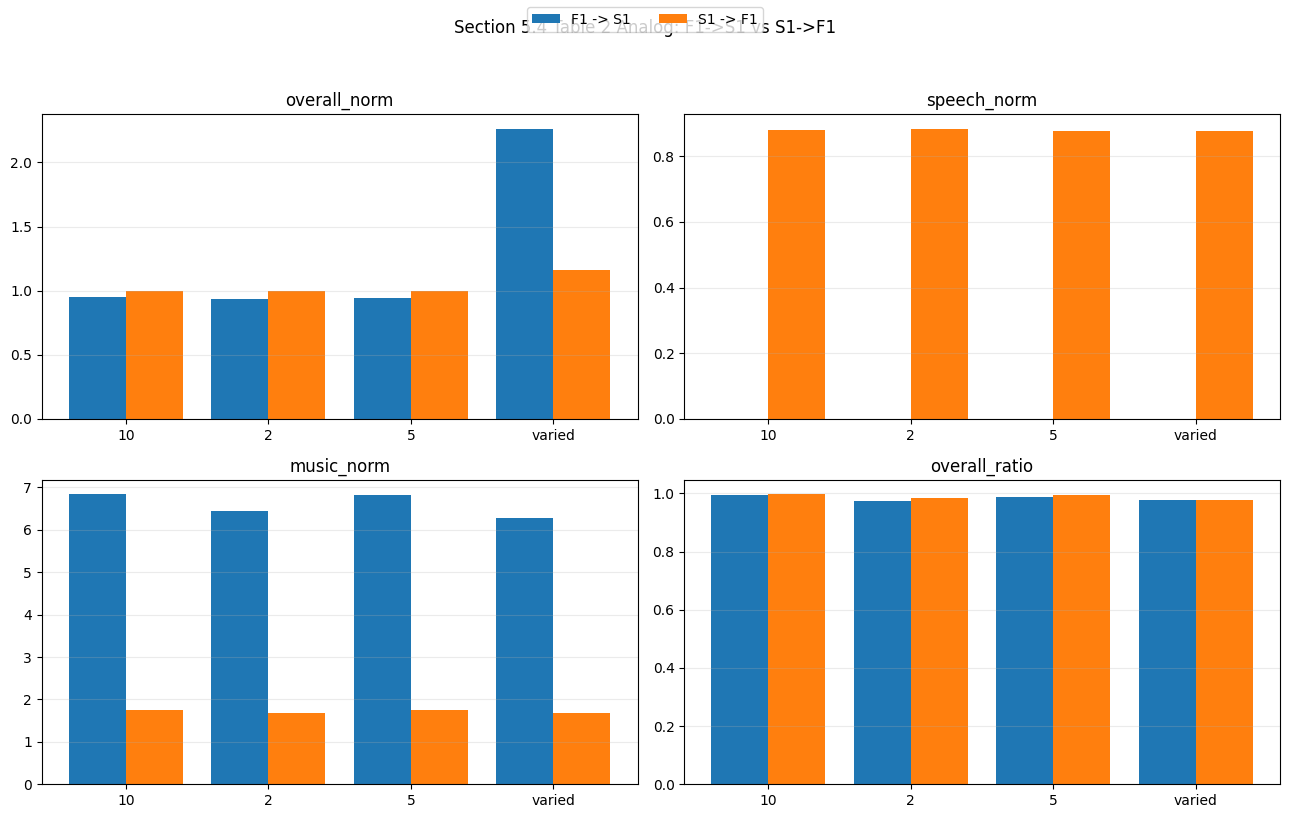

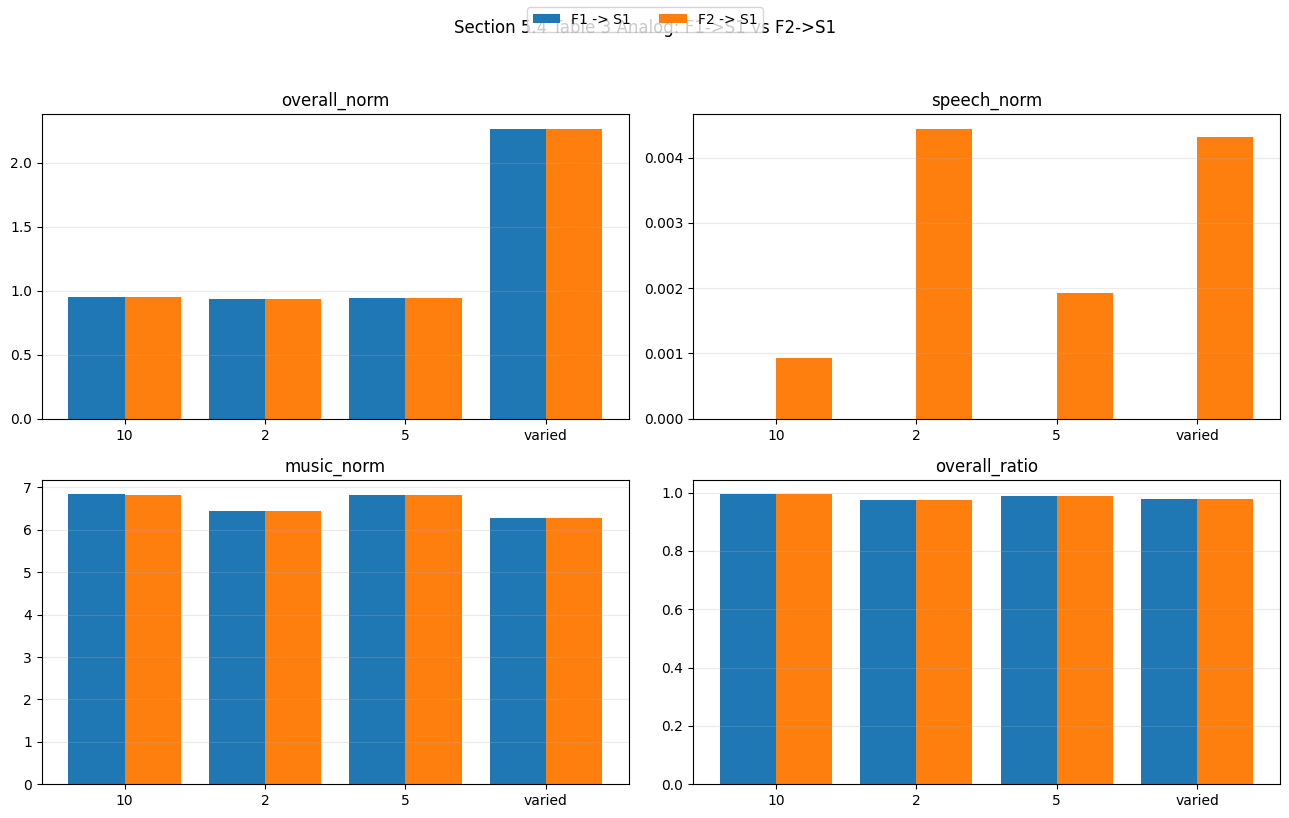

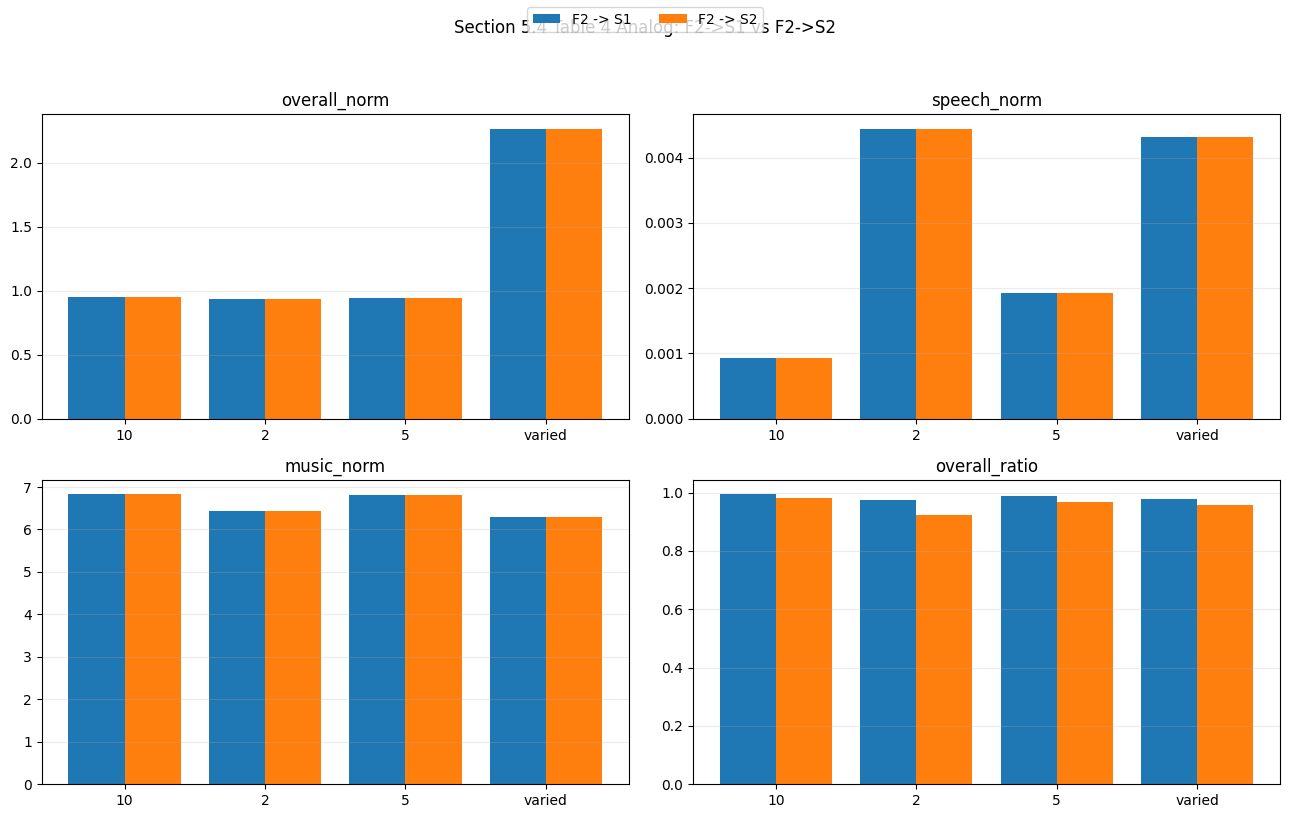

In [26]:

def plot_section54_table(df: pd.DataFrame, title: str):
    """Plot section-5.4 mode-wise normalized metrics for compared variants."""
    modes = sorted(df['mode'].unique(), key=lambda x: str(x))
    variants = list(df['variant'].unique())
    metrics = [*NORM_METRICS, 'overall_ratio']

    fig, axes = plt.subplots(2, 2, figsize=(13, 8.2))
    axes = axes.ravel()

    for ax, metric in zip(axes, metrics):
        width = 0.8 / max(len(variants), 1)
        x = np.arange(len(modes))
        for i, v in enumerate(variants):
            d = df[df['variant'] == v].set_index('mode').loc[modes]
            ax.bar(x + (i - (len(variants)-1)/2) * width, d[metric].values, width=width, label=v)

        ax.set_xticks(x)
        ax.set_xticklabels(modes)
        ax.set_title(metric)
        ax.grid(axis='y', alpha=0.25)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=max(1, len(variants)))
    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_section54_table(sec54_table2, 'Section 5.4 Table 2 Analog: F1->S1 vs S1->F1')
plot_section54_table(sec54_table3, 'Section 5.4 Table 3 Analog: F1->S1 vs F2->S1')
plot_section54_table(sec54_table4, 'Section 5.4 Table 4 Analog: F2->S1 vs F2->S2')


## ۱۴) بخش 5.5: انتخاب پارامتر با قید افت دقت و جدول‌های همتا

In [27]:

section55_outputs = run_section55(
    sec54_test_sets,
    sec54_cache,
    float(paper_ms_20m if 'paper_ms_20m' in globals() else baseline_ms_per_frame),
    SEC55_CFG,
)

sec55_search = section55_outputs['search']
sec55_best_filter = section55_outputs['best_filter']
sec55_best_skip = section55_outputs['best_skip']
sec55_best_combined = section55_outputs['best_combined']
sec55_table5 = section55_outputs['table5']

print('Section 5.5 analog - selected parameters (Table 5 analog):')
display(sec55_table5)


Section 5.5 analog - selected parameters (Table 5 analog):


,Mechanism,Filtering threshold triplet,Skip length,N/threshold
0,Filtering,"{30, OR, 1}",-,-
1,Skipping,-,32,1/1
2,Combined,"{30, OR, 1}",32,1/1


In [28]:

sec55_overall = section55_outputs['overall']
sec55_metrics = section55_outputs['metrics']
sec55_table6 = section55_outputs['table6']

print('Section 5.5 analog - effectiveness summary (Table 6 analog, proxy timing/energy):')
display(sec55_table6[['method', *NORM_METRICS, 'overall_ratio', 'exec_ms_per_frame', 'energy_mJ_per_frame_proxy']])


Section 5.5 analog - effectiveness summary (Table 6 analog, proxy timing/energy):


,method,overall_norm,speech_norm,music_norm,overall_ratio,exec_ms_per_frame,energy_mJ_per_frame_proxy
0,Baseline,1.000000,1.000000,1.000000,0.000000,0.041961,0.149546
1,Filtering,1.495963,0.000000,6.457265,0.874188,0.005279,0.018815
2,Skipping,1.002709,1.007085,0.988196,0.969670,0.001273,0.004536
3,Combined,1.495963,0.000000,6.457265,0.995894,0.000172,0.000614


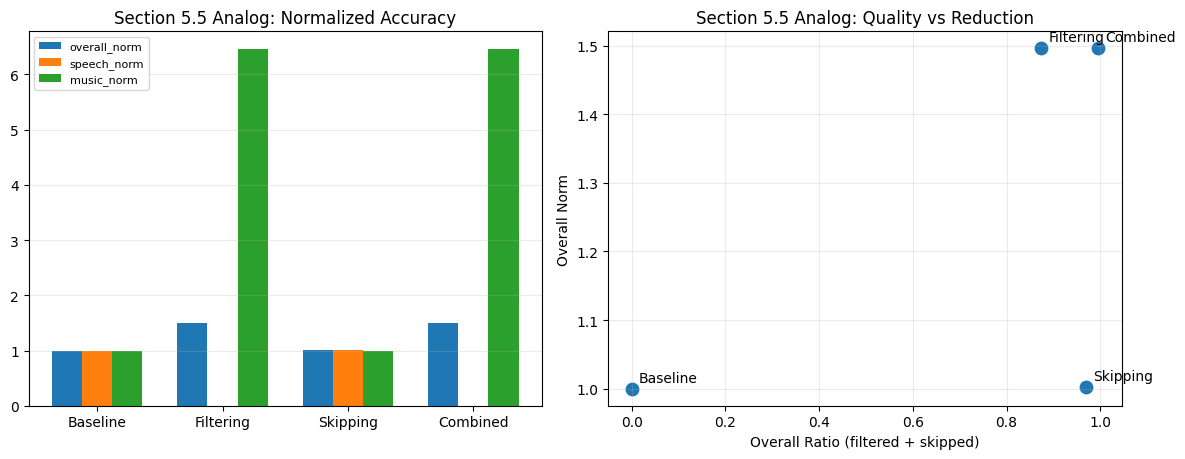

(<Figure size 1200x470 with 2 Axes>,
 array([<Axes: title={'center': 'Section 5.5 Analog: Normalized Accuracy'}>,
        <Axes: title={'center': 'Section 5.5 Analog: Quality vs Reduction'}, xlabel='Overall Ratio (filtered + skipped)', ylabel='Overall Norm'>],
       dtype=object),
       method  n_eval  accuracy  recall_speech  recall_music  precision_speech  precision_music  macro_f1  weighted_f1  overall_ratio  filtered_ratio  skipped_ratio  svm_call_ratio  overall_norm  speech_norm  \
 0   Baseline  541030  0.426492       0.905677      0.154823          0.377925         0.743274  0.394787     0.356504       0.000000        0.000000       0.000000        1.000000      1.000000     1.000000   
 1  Filtering  541030  0.638016       0.000000      0.999734          0.000000         0.638125  0.779011          NaN       0.874188        0.874188       0.000000        0.125812      1.495963     0.000000   
 2   Skipping  541030  0.427647       0.912093      0.152996          0.379078      

In [29]:

plot_norm_bars_and_tradeoff(
    sec55_table6,
    label_col='method',
    title_prefix='Section 5.5 Analog',
    order=METHOD_ORDER,
    figsize=(12, 4.7),
)


## ۱۵) بخش 5.6: تعمیم روش به GMM و WSVM (پیاده‌سازی از صفر)

In [30]:

def logsumexp_np(a: np.ndarray, axis: int = 1) -> np.ndarray:
    """Compute stable log-sum-exp over a chosen axis."""
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)


class DiagGMM:
    def __init__(self, n_components: int = 4, max_iter: int = 80, tol: float = 1e-3, reg_covar: float = 1e-5, seed: int = 42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.seed = seed

    def _log_gauss(self, X: np.ndarray) -> np.ndarray:
        n, d = X.shape
        out = np.empty((n, self.n_components), dtype=np.float64)
        for k in range(self.n_components):
            var = self.vars_[k]
            mean = self.means_[k]
            log_det = np.sum(np.log(2.0 * np.pi * var))
            quad = np.sum(((X - mean) ** 2) / var, axis=1)
            out[:, k] = -0.5 * (log_det + quad) + np.log(self.weights_[k] + 1e-12)
        return out

    def fit(self, X: np.ndarray):
        X = np.asarray(X, dtype=np.float64)
        n, d = X.shape
        rng = np.random.default_rng(self.seed)

        idx = rng.choice(n, size=self.n_components, replace=False if n >= self.n_components else True)
        self.means_ = X[idx].copy()
        self.vars_ = np.tile(np.var(X, axis=0, keepdims=True) + self.reg_covar, (self.n_components, 1))
        self.weights_ = np.full((self.n_components,), 1.0 / self.n_components, dtype=np.float64)

        prev_ll = -1e18
        for _ in range(self.max_iter):
            log_prob = self._log_gauss(X)
            log_norm = logsumexp_np(log_prob, axis=1)
            ll = float(np.mean(log_norm))

            resp = np.exp(log_prob - log_norm[:, None])
            nk = np.sum(resp, axis=0) + 1e-12

            self.weights_ = nk / np.sum(nk)
            self.means_ = (resp.T @ X) / nk[:, None]

            ex2 = (resp.T @ (X * X)) / nk[:, None]
            var = ex2 - self.means_ * self.means_
            self.vars_ = np.maximum(var, self.reg_covar)

            if abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

        return self

    def score_samples(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=np.float64)
        log_prob = self._log_gauss(X)
        return logsumexp_np(log_prob, axis=1)


class WeightedTorchRBFSVM:
    def __init__(self, feature_weights: np.ndarray, **svm_kwargs):
        self.w = np.asarray(feature_weights, dtype=np.float32)
        self.base = TorchRBFSVM(**svm_kwargs)

    def _tx(self, X: np.ndarray) -> np.ndarray:
        return X * self.w[None, :]

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.base.fit(self._tx(X), y)
        return self

    def decision_function(self, X: np.ndarray, batch: int = 512) -> np.ndarray:
        return self.base.decision_function(self._tx(X), batch=batch)


def compute_wsvm_feature_weights(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Compute WSVM per-feature scaling weights from class statistics."""
    X1 = X[y == LABEL_SPEECH]
    X2 = X[y == LABEL_MUSIC]
    m1 = X1.mean(axis=0)
    m2 = X2.mean(axis=0)
    v1 = X1.var(axis=0)
    v2 = X2.var(axis=0)
    w = np.abs(m1 - m2) / (np.sqrt(v1 + v2) + 1e-6)
    w = np.clip(w, 1e-4, None)
    w = w / np.mean(w)
    return w.astype(np.float32)


sec56_X_train = X_train
sec56_y_train = y_train


sec56_gmm_speech = DiagGMM(n_components=4, max_iter=80, tol=1e-3, seed=SEED + 100).fit(sec56_X_train[sec56_y_train == LABEL_SPEECH])
sec56_gmm_music = DiagGMM(n_components=4, max_iter=80, tol=1e-3, seed=SEED + 101).fit(sec56_X_train[sec56_y_train == LABEL_MUSIC])


def sec56_gmm_score_norm(Xn: np.ndarray) -> np.ndarray:
    """Return normalized-frame GMM log-likelihood ratio score."""
    ll_s = sec56_gmm_speech.score_samples(Xn)
    ll_m = sec56_gmm_music.score_samples(Xn)
    return (ll_s - ll_m).astype(np.float32)


sec56_gmm_train_scores = sec56_gmm_score_norm(sec56_X_train)
sec56_gmm_thr, sec56_gmm_ba = calibrate_threshold_balanced_local(sec56_gmm_train_scores, sec56_y_train)


sec56_w_weights = compute_wsvm_feature_weights(sec56_X_train, sec56_y_train)
sec56_wsvm = WeightedTorchRBFSVM(sec56_w_weights, **SVM_PARAMS)
_t0 = time.perf_counter()
sec56_wsvm.fit(sec56_X_train, sec56_y_train)
sec56_wsvm_train_sec = time.perf_counter() - _t0
sec56_wsvm_train_scores = sec56_wsvm.decision_function(sec56_X_train)
sec56_wsvm_thr, sec56_wsvm_ba = calibrate_threshold_balanced_local(sec56_wsvm_train_scores, sec56_y_train)

print('GMM threshold / train BA:', sec56_gmm_thr, sec56_gmm_ba)
print('WSVM train seconds:', sec56_wsvm_train_sec)
print('WSVM threshold / train BA:', sec56_wsvm_thr, sec56_wsvm_ba)
print('WSVM feature weights:', np.round(sec56_w_weights, 4))



def sec56_gmm_score_raw(raw: np.ndarray) -> np.ndarray:
    """Score raw frames with normalized GMM classifier."""
    return sec56_gmm_score_norm(normalize_features(raw))


def sec56_wsvm_score_raw(raw: np.ndarray) -> np.ndarray:
    """Score raw frames with normalized WSVM classifier."""
    return sec56_wsvm.decision_function(normalize_features(raw))


sec56_cache_gmm, sec56_ms_gmm = build_baseline_cache_from_raw_score_fn(paper_test_sets, sec56_gmm_score_raw, sec56_gmm_thr)
sec56_cache_wsvm, sec56_ms_wsvm = build_baseline_cache_from_raw_score_fn(paper_test_sets, sec56_wsvm_score_raw, sec56_wsvm_thr)

print('GMM baseline ms/frame:', sec56_ms_gmm)
print('WSVM baseline ms/frame:', sec56_ms_wsvm)


GMM threshold / train BA: -0.16632769197225572 0.7832
WSVM train seconds: 6.597510661998967
WSVM threshold / train BA: -109.22958984375 0.4968
WSVM feature weights: [4.0349 0.3325 0.3452 0.9535 0.1153 0.2185]
GMM baseline ms/frame: 0.0004147242177884995
WSVM baseline ms/frame: 0.027937181729172214


In [31]:

section56_inputs = {
    'GMM': {'cache': sec56_cache_gmm, 'baseline_ms': sec56_ms_gmm},
    'WSVM': {'cache': sec56_cache_wsvm, 'baseline_ms': sec56_ms_wsvm},
}

section56_outputs = run_section56(
    paper_test_sets,
    section56_inputs,
    SEC56_CFG,
    SEC56_ENERGY_FACTOR,
)

sec56_best_by_classifier = section56_outputs['best_by_classifier']
sec56_table7 = section56_outputs['table7']
sec56_table8 = section56_outputs['table8']


In [32]:

print('Section 5.6 analog - Table 7 (selected params):')
display(sec56_table7)


Section 5.6 analog - Table 7 (selected params):


,Classifier,Mechanism,Filtering threshold triplet,Skip length,N/threshold
0,GMM,Filtering,"{50, OR, 1}",-,-
1,GMM,Skipping,-,17,2/2
2,GMM,Combined,"{70, OR, 1}",32,8/8
3,WSVM,Filtering,"{50, OR, 1}",-,-
4,WSVM,Skipping,-,32,1/1
5,WSVM,Combined,"{50, OR, 1}",32,1/1


In [33]:

print('Section 5.6 analog - Table 8 (effectiveness):')
display(sec56_table8)


Section 5.6 analog - Table 8 (effectiveness):


,Row,Classifier,Method,overall_norm,speech_norm,music_norm,overall_ratio,exec_ms_per_frame,energy_mJ_per_frame_proxy
0,GMM,GMM,Baseline,1.000000,1.000000,1.000000,0.000000,0.000415,0.001663
1,GMM+F,GMM,Filtering,0.851065,0.000000,1.421950,0.874188,0.000052,0.000209
2,GMM+S,GMM,Skipping,0.988144,0.983381,0.991339,0.933441,0.000028,0.000111
3,GMM+C,GMM,Combined,0.851065,0.000000,1.421950,0.995894,0.000002,0.000007
4,WSVM,WSVM,Baseline,1.000000,1.000000,1.000000,0.000000,0.027937,0.099320
5,WSVM+F,WSVM,Filtering,1.786141,0.000000,894.264249,0.874188,0.003515,0.012496
6,WSVM+S,WSVM,Skipping,1.000797,1.000757,1.020725,0.969670,0.000847,0.003012
7,WSVM+C,WSVM,Combined,1.786141,0.000000,894.264249,0.995894,0.000115,0.000408


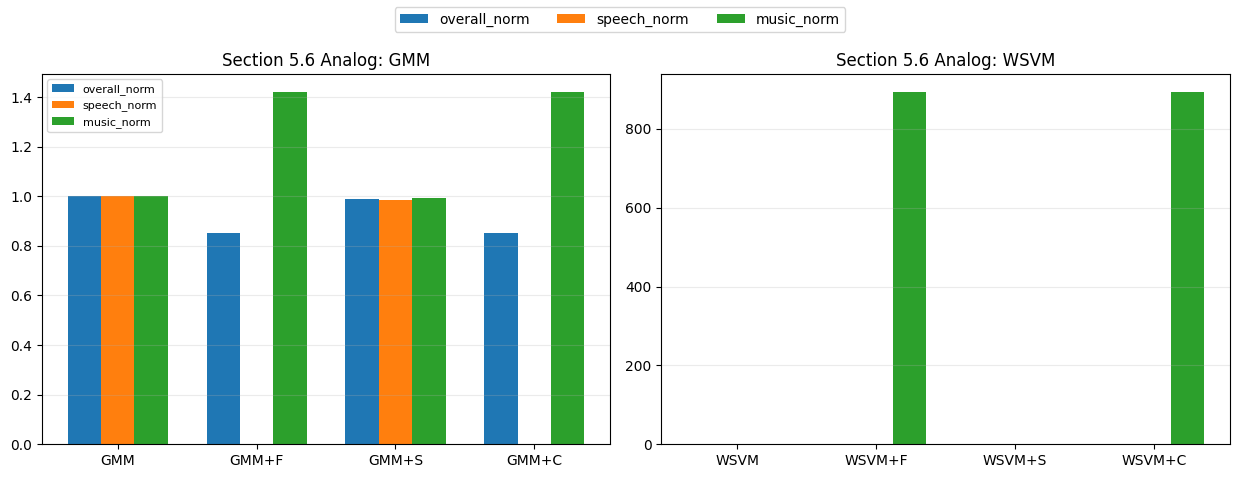

In [34]:

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4.8))

for i, classifier_name in enumerate(['GMM', 'WSVM']):
    classifier_df = sec56_table8[sec56_table8['Classifier'] == classifier_name].copy()
    row_order = [classifier_name, f'{classifier_name}+F', f'{classifier_name}+S', f'{classifier_name}+C']
    plot_norm_bars(
        axes[i],
        classifier_df,
        label_col='Row',
        order=row_order,
        title=f'Section 5.6 Analog: {classifier_name}',
        show_legend=(i == 0),
    )

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## ۱۶) بخش 5.7: ارزیابی روی داده متفاوت با پروکسی انتقال (همتای جدول‌های ۹ و ۱۰)

In [35]:

def sec57_degrade_feature_stream(raw: np.ndarray, seed: int) -> np.ndarray:
    """Create a deterministic feature-space degraded proxy stream for section-5.7 analysis."""
    rng = np.random.default_rng(seed)
    x = np.asarray(raw, dtype=np.float32).copy()

    gains = np.array([0.97, 1.01, 0.99, 0.98, 1.00, 1.00], dtype=np.float32)
    noise = np.array([0.08, 0.03, 0.03, 0.03, 1.00, 2.50], dtype=np.float32)
    x = x * gains[None, :] + rng.normal(0.0, noise[None, :], size=x.shape).astype(np.float32)

    y = np.empty_like(x)
    y[0] = x[0]
    a = 0.86
    for t in range(1, x.shape[0]):
        y[t] = a * y[t - 1] + (1.0 - a) * x[t]

    y[:, :4] = np.round(y[:, :4], 3)
    y[:, 4] = np.clip(np.round(y[:, 4], 1), 0.0, None)
    y[:, 5] = np.clip(np.round(y[:, 5], 1), 0.0, None)

    return y.astype(np.float32)


sec57_test_sets = {}
for mode, files in paper_test_sets.items():
    mode_rows = []
    for f in files:
        mode_code = sum(ord(ch) for ch in str(mode))
        seed = int(np.uint32(SEED * 1009 + mode_code * 97 + (f['file_id'] + 1) * 10007))
        mode_rows.append({
            'mode': str(mode),
            'file_id': f['file_id'],
            'raw': sec57_degrade_feature_stream(f['raw'], seed),
            'y_true': f['y_true'].copy(),
        })
    sec57_test_sets[str(mode)] = mode_rows


def sec57_svm_score_raw(raw: np.ndarray) -> np.ndarray:
    """Score degraded raw frames with normalized SVM classifier."""
    return svm.decision_function(normalize_features(raw))


sec57_cache_svm, sec57_ms_svm = build_baseline_cache_from_raw_score_fn(sec57_test_sets, sec57_svm_score_raw, best_thr)
print('Section 5.7 baseline ms/frame:', sec57_ms_svm)


Section 5.7 baseline ms/frame: 0.03930984041894277


In [36]:

section57_outputs = run_section57(
    sec57_test_sets,
    sec57_cache_svm,
    sec57_ms_svm,
    SEC57_CFG,
)

sec57_search = section57_outputs['search']
sec57_best_filter = section57_outputs['best_filter']
sec57_best_skip = section57_outputs['best_skip']
sec57_best_combined = section57_outputs['best_combined']
sec57_table9 = section57_outputs['table9']
sec57_overall = section57_outputs['overall']
sec57_metrics = section57_outputs['metrics']
sec57_table10 = section57_outputs['table10']

print('Section 5.7 analog - Table 9 (selected params for degraded dataset proxy):')
display(sec57_table9)

print('Section 5.7 analog - Table 10 (effectiveness on degraded dataset proxy):')
display(sec57_table10)


Section 5.7 analog - Table 9 (selected params for degraded dataset proxy):


,Mechanism,Filtering threshold triplet,Skip length,N/threshold
0,Filtering,"{60, OR, 4}",-,-
1,Skipping,-,32,1/1
2,Combined,"{60, OR, 4}",32,1/1


Section 5.7 analog - Table 10 (effectiveness on degraded dataset proxy):


,Row,overall_norm,speech_norm,music_norm,overall_ratio,exec_ms_per_frame,energy_mJ_per_frame_proxy
0,Base,1.000000,1.000000,1.000000,0.000000,0.039310,0.140090
1,Filtering,1.466766,0.003137,6.172726,0.882307,0.004626,0.016488
2,Skipping,1.006372,1.009561,0.996120,0.969670,0.001192,0.004249
3,Combined,1.466766,0.003137,6.172726,0.995960,0.000159,0.000566


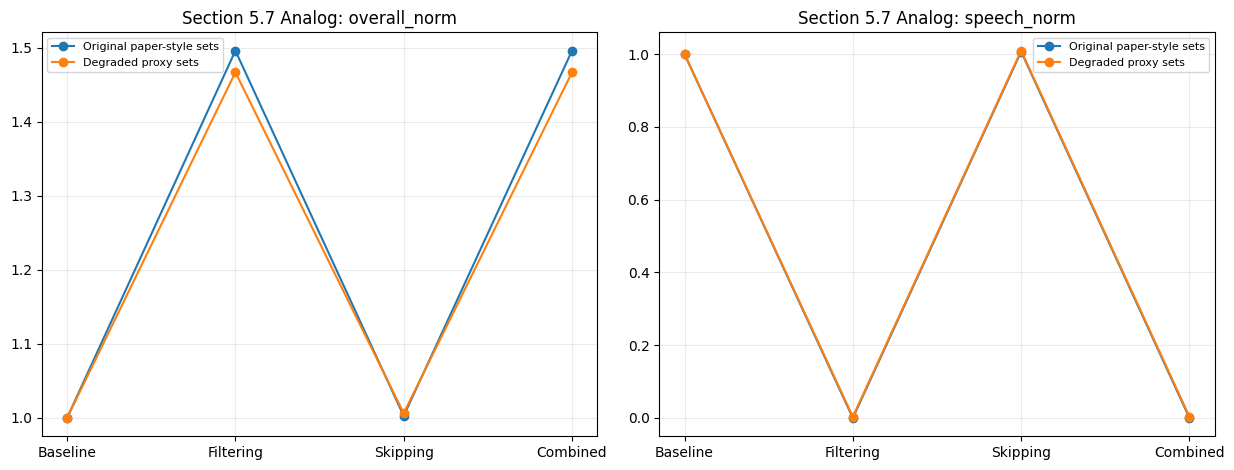

In [37]:

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4.8))

orig = sec55_table6[['method', *NORM_METRICS, 'overall_ratio']].copy()
orig['dataset'] = 'Original paper-style sets'

newd = sec57_table10.copy()
newd = newd.rename(columns={'Row': 'method'})
newd = newd[newd['method'].isin(['Base', 'Filtering', 'Skipping', 'Combined'])].copy()
newd['method'] = newd['method'].replace({'Base': 'Baseline'})
newd['dataset'] = 'Degraded proxy sets'
newd = newd[['method', *NORM_METRICS, 'overall_ratio', 'dataset']]

cmp_df = pd.concat([orig, newd], ignore_index=True)

for i, metric in enumerate(SECTION57_COMPARE_METRICS):
    plot_norm_line_compare(
        axes[i],
        cmp_df,
        label_col='method',
        dataset_col='dataset',
        metric_col=metric,
        order=METHOD_ORDER,
        title=f'Section 5.7 Analog: {metric}',
    )

plt.tight_layout()
plt.show()


## ۱۷) جمع‌بندی نهایی
در این نوت‌بوک موارد زیر به‌صورت کامل پوشش داده شده‌اند:
1. پیاده‌سازی SVM پایه و سه مکانیزم فیلترینگ، پرش، و ترکیبی.
2. پوشش هر دو نوع مکانیزم پرش مقاله (تاریخچه برچسب و تاریخچه خروجی SVM).
3. تحلیل‌های حساسیت و نمودارهای مقایسه‌ای مطابق ساختار تجربی مقاله.
4. جدول‌ها و تحلیل‌های تکمیلی بخش‌های 5.4 تا 5.7.

محدودیت‌های باقی‌مانده پروژه:
- نبود دیتاست دقیق TIMIT + CDهای تجاری مورد استفاده مقاله،
- نبود مسیر دقیق ویژگی‌های fixed-point داخلی SMV،
- نبود شبیه‌ساز SimpleScalar برای زمان/انرژی واقعی،
- جایگزینی دیتاست انتقال‌یافته واقعی Bluetooth+G.722 با یک پروکسی بازتولیدپذیر.


## مراجع
1. Lim, C., & Chang, J.-H. (2015). *Efficient implementation techniques of an SVM-based speech/music classifier in SMV*. Multimedia Tools and Applications, 74, 5375–5400. DOI: 10.1007/s11042-014-1859-8
2. 3GPP2. *Selectable Mode Vocoder (SMV) service option for wideband spread spectrum communication systems* (3GPP2-C.S0030-0, v3.0), 2004.
3. Kim, S. K., & Chang, J. H. (2009). *Speech/music classification enhancement for 3GPP2 SMV codec based on support vector machine*.
4. Song, J. et al. (2011). *Enhancement of speech/music decision employing GMM for SMV codec*.
5. Kim, S. K., & Chang, J. H. (2010). *Weighted SVM-based speech/music classification in 3GPP2 SMV codec*.
